In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
import nibabel as nib
from nilearn.plotting import plot_img, plot_stat_map, view_img, plot_prob_atlas
from nilearn.regions import connected_label_regions
from nilearn.glm.first_level.hemodynamic_models import spm_hrf
from nilearn.image import concat_imgs, mean_img, index_img, smooth_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
from nilearn.plotting import plot_roi
from nilearn.maskers import NiftiMapsMasker, NiftiSpheresMasker
from scipy.interpolate import interp1d
import seaborn as sns
from scipy.stats.mstats import pearsonr
from scipy.stats import zscore
import scipy.stats as stats
import statsmodels.api as sm
from nilearn.image import high_variance_confounds


/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


- Compare released and un-released movies. 
- Onset of NAcc and middle MPFC. 
- MPFC 2 tr after nacc and ains.

Okay, as I understand it: 
1) Mean center valence and arousal scores. 
2) To obtain positive and negative arousal scores use 
- Pos_arousal -> (arousal_i - valence_i)/sqrt(2)
- Neg_arousal -> (arousal_i - valence_i)/sqrt(2)

- Split like and no-like horror movies. 

- operationalize peak as delta (x_1 - x_2)/(x_1 + x_2)
- Also, calculate slope between tr_1 and tr_2 that crosses a 1 std. 
- Get the highest correlation for comedy, see when TR happens. 

- What to do if there's more than one peak (i.e., if there's more than two points higher than std)?
- Try region coupling (MPFC-NAcc, MPFC-AIns, NAcc-AIns).


# Homemade functions

In [2]:
def Merge(dict1, dict2):

    # create a new dictionary by merging the items of the two dictionaries using the union operator (|)
    merged_dict = dict(dict1.items() | dict2.items())
    
    # return the merged dictionary
    return merged_dict

def merge_dictionaries(dict1, dict2):
    merged_dict = dict1.copy()
    merged_dict.update(dict2)
    return merged_dict

In [3]:
def process_clean_df(path, filter_threshold):

    # Load dataset. 
    all_subs_events_df = pd.read_csv(path)

    # Create dataframe to store cooks scores. 
    all_cooks_df = pd.DataFrame()
    participants_list = all_subs_events_df['Participant'].unique()

    for sub_id in participants_list: 

        # Get dataframe of current subject.
        current_sub_df = all_subs_events_df[all_subs_events_df['Participant'] == sub_id]
        current_sub_cooks_df = pd.DataFrame()

        # Define response variable.
        Y = current_sub_df['W_score_scaled']

        # Define explanatory variables for each model.
        X_affect = current_sub_df[['Pos_arousal_scaled', 'Neg_arousal_scaled']]
        X_whole = current_sub_df[['NAcc_whole', 'AIns_whole', 'MPFC_whole']]
        X_onset = current_sub_df[['NAcc_onset', 'AIns_onset', 'MPFC_onset']]
        X_middle = current_sub_df[['NAcc_middle', 'AIns_middle', 'MPFC_middle']]
        X_offset = current_sub_df[['NAcc_offset', 'AIns_offset', 'MPFC_offset']]
        X_ind_peaks_pos = current_sub_df[['NAcc_ind_peaks_pos', 'AIns_ind_peaks_pos', 'MPFC_ind_peaks_pos']]
        X_ind_peaks_neg = current_sub_df[['NAcc_ind_peaks_neg', 'AIns_ind_peaks_neg', 'MPFC_ind_peaks_neg']]

        # Add constant to predictor variables.
        X_affect = sm.add_constant(X_affect)
        X_whole = sm.add_constant(X_whole)
        X_onset = sm.add_constant(X_onset)
        X_middle = sm.add_constant(X_middle)
        X_offset = sm.add_constant(X_offset)
        X_ind_peaks_pos = sm.add_constant(X_ind_peaks_pos)
        X_ind_peaks_neg = sm.add_constant(X_ind_peaks_neg)

        # Fit linear regression models
        model_affect = sm.OLS(Y.astype(float), X_affect.astype(float)).fit()
        model_whole = sm.OLS(Y.astype(float), X_whole.astype(float)).fit()
        model_onset = sm.OLS(Y.astype(float), X_onset.astype(float)).fit()
        model_middle = sm.OLS(Y.astype(float), X_middle.astype(float)).fit()
        model_offset = sm.OLS(Y.astype(float), X_offset.astype(float)).fit()
        model_ind_peaks_pos = sm.OLS(Y.astype(float), X_ind_peaks_pos.astype(float)).fit()
        model_ind_peaks_neg = sm.OLS(Y.astype(float), X_ind_peaks_neg.astype(float)).fit()

        # Create instance of influence for each model.
        influence_affect = model_affect.get_influence()
        influence_whole = model_whole.get_influence()
        influence_onset = model_onset.get_influence()
        influence_middle = model_middle.get_influence()
        influence_offset = model_offset.get_influence()
        influence_ind_peaks_pos = model_ind_peaks_pos.get_influence()
        influence_ind_peaks_neg = model_ind_peaks_neg.get_influence()

        # Obtain Cook's distance for each observation in each model.
        affect_cooks_scores = influence_affect.cooks_distance
        whole_cooks_scores = influence_whole.cooks_distance
        onset_cooks_scores = influence_onset.cooks_distance
        middle_cooks_scores = influence_middle.cooks_distance
        offset_cooks_scores = influence_offset.cooks_distance
        ind_peaks_pos_cooks_scores = influence_ind_peaks_pos.cooks_distance
        ind_peaks_neg_cooks_scores = influence_ind_peaks_neg.cooks_distance

        # Add Cook's distance to the dataframe.
        current_sub_cooks_df["Participant_cooks"] = current_sub_df["Participant"]
        current_sub_cooks_df["Affect_cooks"] = affect_cooks_scores[0]
        current_sub_cooks_df["Whole_cooks"] = whole_cooks_scores[0]
        current_sub_cooks_df["Onset_cooks"] = onset_cooks_scores[0]
        current_sub_cooks_df["Middle_cooks"] = middle_cooks_scores[0]
        current_sub_cooks_df["Offset_cooks"] = offset_cooks_scores[0]
        current_sub_cooks_df["Ind_peaks_pos_cooks"] = ind_peaks_pos_cooks_scores[0]
        current_sub_cooks_df["Ind_peaks_neg_cooks"] = ind_peaks_neg_cooks_scores[0]

        # Append the current subject's Cook's distance to the main dataframe.
        all_cooks_df = pd.concat([all_cooks_df, current_sub_cooks_df], ignore_index=True)

        del current_sub_cooks_df

    # Append cooks columns to main dataframe.
    all_subs_events_df = pd.concat([all_subs_events_df, all_cooks_df], axis=1)

    # Filter out the outliers.
    # Drop rows with Cook's distance higher than the threshold.
    all_subs_events_df = all_subs_events_df[all_subs_events_df['Whole_cooks'] < filter_threshold]
    all_subs_events_df = all_subs_events_df[all_subs_events_df['Onset_cooks'] < filter_threshold]
    #all_subs_events_df = all_subs_events_df[all_subs_events_df['Middle_cooks'] < filter_threshold]
    all_subs_events_df = all_subs_events_df[all_subs_events_df['Offset_cooks'] < filter_threshold]
    #all_subs_events_df = all_subs_events_df[all_subs_events_df['ISC_cooks'] < filter_threshold]
    #all_subs_events_df = all_subs_events_df[all_subs_events_df['Ind_peaks_pos_cooks'] < filter_threshold]
    #all_subs_events_df = all_subs_events_df[all_subs_events_df['Ind_peaks_neg_cooks'] < filter_threshold]
    all_subs_events_df = all_subs_events_df[all_subs_events_df['Affect_cooks'] < filter_threshold]

    return all_subs_events_df       

In [4]:
# Functions to get different peaks (slope and deltas).
def get_peak_slope(timecourse, timecourse_z, z_threshold, max_min):

    # Store all possible peak in timecourse array.
    possible_slope_peaks = []

    # Loop through each point in timecourse array, except the first one.
    for id_tr in range(1, 15, 1):

        # For positive peaks. 
        if(max_min == "max"):

            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(timecourse_z[id_tr] > z_threshold): 

                slope = timecourse[id_tr] - timecourse[id_tr - 1] 
                # Check the slope is not equal to zero. 
                if(slope != 0):
                    possible_slope_peaks.append(slope)
        
        # For negative peaks.
        if(max_min == "min"):

            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(timecourse_z[id_tr] < z_threshold): 

                slope = timecourse[id_tr] - timecourse[id_tr - 1] 
                # Check the slope is not equal to zero. 
                if(slope != 0):
                    possible_slope_peaks.append(slope)
    
    average_slope = np.mean(possible_slope_peaks)

    # Return only the first value and average slope.
    if(len(possible_slope_peaks) == 0):
        return 0, 0
    else: 
        return possible_slope_peaks[0], average_slope

def get_narrow_peak_slope(timecourse, z_threshold, max_min):

    # Z-score the 15 data points.
    z_scored_data = stats.zscore(timecourse)

    # Store all possible peak in timecourse array.
    possible_slope_peaks = []

    # Loop through each point in timecourse array, except the first one.
    for id_tr in range(1, 15, 1):

        # For positive peaks.
        if(max_min == "max"):
            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(z_scored_data[id_tr] > z_threshold): 

                slope = timecourse[id_tr] - timecourse[id_tr - 1] 
                # Check the slope is not equal to zero. 
                if(slope != 0):
                    possible_slope_peaks.append(slope)
    
        # For negative peaks.
        if(max_min == "min"):
            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(z_scored_data[id_tr] < z_threshold): 

                slope = timecourse[id_tr] - timecourse[id_tr - 1] 
                # Check the slope is not equal to zero. 
                if(slope != 0):
                    possible_slope_peaks.append(slope)
    
    average_slope = np.mean(possible_slope_peaks)

    # Return only the first value and average slope.
    if(len(possible_slope_peaks) == 0):
        return 0, 0
    else: 
        return possible_slope_peaks[0], average_slope
    
def get_peak_delta(timecourse, timecourse_z, z_threshold, max_min):

    # Store all possible peak in timecourse array.
    possible_delta_peaks = []

    # Loop through each point in timecourse array, except the first one.
    for id_tr in range(1, 15, 1):

        # For positive peaks. 
        if(max_min == "max"):

            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(timecourse_z[id_tr] > z_threshold): 

                delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr]*100) 
                #delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr] + timecourse[id_tr - 1]) 
                # Check the slope is not equal to zero. 
                if(delta != 0):
                    possible_delta_peaks.append(delta)
        
        # For negative peaks.
        if(max_min == "min"):

            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(timecourse_z[id_tr] < z_threshold): 

                delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr]*100) 
                #delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr] + timecourse[id_tr - 1]) 
                # Check the slope is not equal to zero. 
                if(delta != 0):
                    possible_delta_peaks.append(delta)
    
    average_delta = np.mean(possible_delta_peaks)

    # Return only the first value and average slope.
    if(len(possible_delta_peaks) == 0):
        return 0, 0
    else: 
        return possible_delta_peaks[0], average_delta
    

def get_narrow_peak_delta(timecourse, z_threshold, max_min):

    # Z-score the 15 data points.
    z_scored_data = stats.zscore(timecourse)

    # Store all possible peak in timecourse array.
    possible_delta_peaks = []

    # Loop through each point in timecourse array, except the first one.
    for id_tr in range(1, 15, 1):

        # For positive peaks.
        if(max_min == "max"):
            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(z_scored_data[id_tr] > z_threshold): 

                delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr]*100) 
                #delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr] + timecourse[id_tr - 1]) 
                # Check the slope is not equal to zero. 
                if(delta != 0):
                    possible_delta_peaks.append(delta)
    
        # For negative peaks.
        if(max_min == "min"):
            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(z_scored_data[id_tr] < z_threshold): 

                delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr]*100) 
                #delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr] + timecourse[id_tr - 1]) 
                # Check the slope is not equal to zero. 
                if(delta != 0):
                    possible_delta_peaks.append(delta)
    
    average_delta = np.mean(possible_delta_peaks)

    # Return only the first value and average slope.
    if(len(possible_delta_peaks) == 0):
        return 0, 0
    else: 
        return possible_delta_peaks[0], average_delta
     


In [5]:
def plot_trailer_correlations(ROI_df, Trailer_id, ROI_id, TR_corr_dict, type_of_corr, axs):

    if(type_of_corr == "W_score"):
        color="green"
        bonus_y = 0.00
        score_label = "_w"
        text_label = "W corr"
    elif(type_of_corr == "Pos_arousal"):
        color="blue"
        bonus_y = 0.05
        score_label = "_pa"
        text_label = "PA corr"
    elif(type_of_corr == "Neg_arousal"):
        color="red"
        bonus_y = -0.05
        score_label = "_na"
        text_label = "NA corr"

    if(ROI_id == "Bilateral_NAcc"):
        y_coord_seg = 0.3 + bonus_y
        y_coord_whole = 0.4
    elif(ROI_id == "Bilateral_AIns"):
        y_coord_seg = 0.4 + bonus_y
        y_coord_whole = 0.5
    elif(ROI_id == "Bilateral_MPFC"):
        y_coord_seg = 0.4 + bonus_y
        y_coord_whole = 0.5

    # Get the dataframe for the current trailer.
    current_traile_df = ROI_df[Trailer_id]

    # Loop for plotting each significant correlation across the 15 TRs.
    for TR_id in range(15):
        TR_label = str("TR_" + str(TR_id) + score_label) 
        y_coord = current_traile_df[(current_traile_df["ROI"] == ROI_id) & (current_traile_df["TR"] == TR_id)]["Signal"].mean() + bonus_y
        x_coord = TR_id
        if(TR_corr_dict[Trailer_id][TR_label][1] < 0.05):
            if(TR_corr_dict[Trailer_id][TR_label][0] > 0):
                axs.text(x_coord, y_coord, "+*", fontsize=13, color=color, weight="bold", label=text_label)
            else:
                axs.text(x_coord, y_coord, "-*", fontsize=13, color=color, weight="bold", label=text_label)
    
    # Plot the onset correlation if significant.
    #current_traile_df = ROI_df[Trailer_id]
    Onset_label = str("Onset" + score_label)
    #y_coord_seg = (current_traile_df[(current_traile_df["ROI"] == ROI_id)]["Signal"].mean() ) + bonus_y #* 0.7
    x_coord_onset = 3

    if(TR_corr_dict[Trailer_id][Onset_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Onset_label][0] > 0):
            axs.text(x_coord_onset, y_coord_seg, "on(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_onset, y_coord_seg, "on(-)", fontsize=13, color=color, weight="bold", label=text_label)

    # Plot the middle correlation if significant.
    Middle_label = str("Middle" + score_label)
    x_coord_middle = 7
    if(TR_corr_dict[Trailer_id][Middle_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Middle_label][0] > 0):
            axs.text(x_coord_middle, y_coord_seg, "mid(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_middle, y_coord_seg, "mid(-)", fontsize=13, color=color, weight="bold", label=text_label)

    # Plot the offset correlation if significant.
    Offset_label = str("Offset" + score_label)
    x_coord_offset = 13
    if(TR_corr_dict[Trailer_id][Offset_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Offset_label][0] > 0):
            axs.text(x_coord_offset, y_coord_seg, "off(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_offset, y_coord_seg, "off(-)", fontsize=13, color=color, weight="bold", label=text_label)

    # Plot the whole correlation if significant.
    Whole_label = str("Whole" + score_label)
    x_coord_whole = 7
    #y_coord_whole = (current_traile_df[(current_traile_df["ROI"] == ROI_id)]["Signal"].max() ) + bonus_y # * 0.8
    if(TR_corr_dict[Trailer_id][Whole_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Whole_label][0] > 0):
            axs.text(x_coord_whole, y_coord_whole, "whole(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_whole, y_coord_whole, "whole(-)", fontsize=13, color=color, weight="bold", label=text_label)
    



In [6]:
# Define a function to invert scores if needed. 
def transform_scores(score, invert):
    if(invert==1): #if(not invert):
        if(score == 1):  
            return 4
        elif(score == 2):  
            return 3
        elif(score == 3):  
            return 2
        elif(score == 4):  
            return 1
        elif(score == "1"):  
            return 4
        elif(score == "2"):  
            return 3
        elif(score == "3"):  
            return 2
        elif(score == "4"):  
            return 1
        elif(score == "None"):
            return 0
        else: 
            return "Something went wrong here!"
    else:
        if(score == "1"):
            return 1
        elif(score == "2"):
            return 2
        elif(score == "3"):
            return 3
        elif(score == "4"):
            return 4
        elif(score == 1):
            return 1
        elif(score == 2):
            return 2
        elif(score == 3):
            return 3
        elif(score == 4):
            return 4
        elif(score == "None"):
            return 0
        else:
            return "Something went wrong here!"

In [7]:
def process_events_data(run_dataframe):

    proccesed_events_df = pd.DataFrame(columns={"Trailer", "Type", "Onset", "Duration", "Offset", "W_score", "A_score", "F_score"}) 

    # Initial fixation 12 sec (TR=6).
    in_fix = 12

    # Time it take subjects to complete questionnaire 12 sec (TR=6). 
    questionnaire_duration = 12

    # All trailers last 30 sec (TR=15). 
    trailer_duration = 30

    # Initialize this variable, though it will change through each iteration of the loop.
    trailer_onset = 0

    # Run a for loop for each row in the df. 
    for id in range(run_dataframe.shape[0]):

        # Get trailer label and separate them accroding to their type. 
        trailer_name = run_dataframe["label"][id]
        trailer_type = "Horror" if "h" in run_dataframe["label"][id] else "Comedy"

        # This onsets don't work, so I need to re-calculate them
        traile_iti = run_dataframe["trial_ITI"][id]
        
        # For the first run add the initial fixation time to the calculation of the first trailer onset. 
        # After the first run, calculate onset by adding previous traile onset, questionnaire duration, and trial iti.
        if (id == 0):
            trailer_onset += in_fix
        else:
            trailer_onset += trailer_duration + questionnaire_duration + traile_iti

        # Calculate trailer onset. 
        trailer_offset = trailer_onset + 30 

        """ 
        For the questionnaire scores, as I understood it. If they were not inverted (["scale_flip"] == 0), then 
        the lower the score the stronger the response. If they were inverted (["scale_flip"] == 1), the higher the 
        score the stronger the response.
        """
        # Check if scaled was flipped and put scores on the same scale. 
        # For me, the most intuitive is that the higher the score, the stronger the response. 
        trailer_watch_score = transform_scores(run_dataframe["exp_Watch.keys"][id], run_dataframe["scale_flip"][id])
        trailer_arousal_score = transform_scores(run_dataframe["exp_Arousal.keys"][id], run_dataframe["scale_flip"][id])
        trailer_feel_score = transform_scores(run_dataframe["exp_Feel.keys"][id], run_dataframe["scale_flip"][id])

        # Place processed data on list, add list to new dataframe, and concat to main dataframe. 
        current_row_data = [[trailer_name, trailer_type, trailer_onset, trailer_duration, trailer_offset, trailer_watch_score, trailer_arousal_score, trailer_feel_score]]
        current_row = pd.DataFrame(data=current_row_data, columns=["Trailer", "Type", "Onset", "Duration", "Offset", "W_score", "A_score", "F_score"]) 
        proccesed_events_df = pd.concat([proccesed_events_df, current_row], ignore_index=True)
        proccesed_events_df = proccesed_events_df[["Trailer", "Type", "Onset", "Offset", "Duration", "W_score", "A_score", "F_score"]]

    # Add a column for the mean centered arousal and valence scores.
    mean_centered_arousal = proccesed_events_df["A_score"]/proccesed_events_df["A_score"].mean()
    mean_centered_valence = proccesed_events_df["F_score"]/proccesed_events_df["F_score"].mean()

    # Derive the positive and negative arousal scores.
    proccesed_events_df["Pos_arousal"] = (mean_centered_arousal+mean_centered_valence)/np.sqrt(2)
    proccesed_events_df["Neg_arousal"] = (mean_centered_arousal-mean_centered_valence)/np.sqrt(2)

    # Derive the positive and negative arousal scaled scores. 
    pos_arousal_mean = proccesed_events_df["Pos_arousal"].mean()
    neg_arousal_mean = proccesed_events_df["Neg_arousal"].mean()

    pos_arousal_std = np.std(proccesed_events_df["Pos_arousal"], axis=0, ddof=1)
    neg_arousal_std = np.std(proccesed_events_df["Neg_arousal"], axis=0, ddof=1)

    proccesed_events_df["Pos_arousal_scaled"] = (proccesed_events_df["Pos_arousal"] - pos_arousal_mean)
    proccesed_events_df["Neg_arousal_scaled"] = (proccesed_events_df["Neg_arousal"] - neg_arousal_mean)

    # Derive scales Watch scores. 
    watch_score_mean = proccesed_events_df["W_score"].mean()    
    watch_score_std = np.std(proccesed_events_df["W_score"], axis=0, ddof=1)
    proccesed_events_df["W_score_scaled"] = (proccesed_events_df["W_score"] - watch_score_mean)

    return proccesed_events_df

In [8]:
def access_trailer(dictionary, trailer_key): 
    try:
        trailer_data = dictionary[trailer_key]
        return trailer_data
    except KeyError:
        pass    

def access_timecourse(dictionary, roi_key):
    
    dictionary_keys = list(dictionary.keys())

    if((roi_key in dictionary_keys) and (dictionary[roi_key] is not None) and (dictionary[roi_key] is not "None")):
        roi_data = np.array(dictionary[roi_key])
        return roi_data
    
    
    # try:
    #     print(dictionary)
    #     if(dictionary[roi_key] == None):
    #         print("This is empty!")
    #         print(dictionary[roi_key])
    #     if(dictionary[roi_key] is not None):
    #         roi_data = np.array(dictionary[roi_key])
    #         return roi_data
    
    # except KeyError:
    #     pass


def trim_timecourse_per_roi(timecourses_dictionary_list, timecourses_dictionary_raw, ROI):

    # 1) Create a new dictionary to store the trimmed timecourses.
    # First file will store the avg timecourse for each trailer per roi (ROI x trailer).
    # Second file will store the timecourse of all subjects for each trailer per roi (ROI x subjects x trailer).
    # Third file will store the timecourse of all subjects for each trailer per roi in a dataframe (ROI x subjects x trailer).
    all_subjects_avg_ROI_timecourse = {}
    all_subjects_ROI_timecourse = {}
    all_subjects_ROI_timecourse_df = {}

    bROI = "Bilateral_" + ROI
    bROI_r1 = "Bilateral_" + ROI + "_r1"
    bROI_r2 = "Bilateral_" + ROI + "_r2"
    rROI = "Right_" + ROI
    rROI_r1 = "Right_" + ROI + "_r1"
    rROI_r2 = "Right_" + ROI + "_r2"
    lROI = "Left_" + ROI
    lROI_r1 = "Left_" + ROI + "_r1"
    lROI_r2 = "Left_" + ROI + "_r2"

    # Get all keys from the first participant dictionary.
    trailer_list = list(timecourses_dictionary_list["sub-01"].keys())
    subjects_list = list(timecourses_dictionary_raw.keys())

    if(ROI != "V1"):
        # Loop through all trailer keys.
        for id in range(len(trailer_list)): 
    
            # Create new participant list with only participants that have the current trailer.
            participants_with_trailer = [d for d in timecourses_dictionary_list if trailer_list[id] in timecourses_dictionary_list[d]] # Store participant id if they have the current trailer.
        
            # Make copy of dictionary with only participants that have the current trailer.
            timecourses_dictionary_list_current_trailer = {k: timecourses_dictionary_list[k] for k in participants_with_trailer}
        
            # Loop through all participants and get the values for the current trailer.
            # Note, a wrapper function just to return the values for the current trailer.
            # if they exist, otherwise return None.
            values = [access_trailer(timecourses_dictionary_list_current_trailer[d], trailer_list[id]) for d in timecourses_dictionary_list_current_trailer] 
        
            values_Bilateral_ROI = [values[d][bROI] for d in range(len(values))]
            values_Right_ROI = [values[d][rROI] for d in range(len(values))]
            values_Left_ROI = [values[d][lROI] for d in range(len(values))]

            # Compute the average for each roi.
            averageBilateral_ROI = np.mean(values_Bilateral_ROI, axis=0)
            averageRight_ROI = np.mean(values_Right_ROI, axis=0)
            averageLeft_ROI = np.mean(values_Left_ROI, axis=0)

            # Row are timepoints, columns are participants (15 x P).
            values_Bilateral_ROI_array = np.array(values_Bilateral_ROI).T 
            values_Right_ROI_array = np.array(values_Right_ROI).T
            values_Left_ROI_array = np.array(values_Left_ROI).T

            # Create columns names for the dataframe.
            TRs = np.arange(0, 15, 1)

            # Creat empty dataframe for current trailer. 
            trailer_df = pd.DataFrame(columns=["Participant", "ROI", "Signal", "TR"])   

            current_participant_dic = {}

            for current_participant in range(len(participants_with_trailer)):

                # Create dictionary with all the timecourses for all trailers for each subject.
                current_participant_dic[participants_with_trailer[current_participant]] = {bROI: values_Bilateral_ROI_array[:, current_participant],
                                                                                       lROI: values_Left_ROI_array[:, current_participant], 
                                                                                       rROI: values_Right_ROI_array[:, current_participant]}
 
                participant_col = np.repeat(str(participants_with_trailer[current_participant]), 15)
                label_bi = np.repeat(bROI, 15)
                label_left = np.repeat(lROI, 15)
                label_right = np.repeat(rROI, 15)
                roi_labels = [label_bi, label_left, label_right]

                # Store current participant values. 
                current_participant_bi = values_Bilateral_ROI_array[:, current_participant]
                current_participant_left = values_Left_ROI_array[:, current_participant]
                current_participant_right = values_Right_ROI_array[:, current_participant]
                current_participant_values = [current_participant_bi, current_participant_left, current_participant_right]

                for x in range(3):

                    current_participant_roi_data = {
                        "Participant": participant_col,
                        "ROI": roi_labels[x],
                        "Signal": current_participant_values[x],
                        "TR": TRs
                    }
            
                    participant_df = pd.DataFrame(data=current_participant_roi_data)

                    trailer_df = pd.concat([trailer_df, participant_df], ignore_index=True)
        
            # store the all in the results dictionaries.
            all_subjects_avg_ROI_timecourse[trailer_list[id]] = {bROI: averageBilateral_ROI, lROI: averageLeft_ROI, rROI: averageRight_ROI}
            all_subjects_ROI_timecourse[trailer_list[id]] = current_participant_dic
            all_subjects_ROI_timecourse_df[trailer_list[id]] = trailer_df
    
    # Get average timecourse for all subjects in the current ROI. 
    Bilateral_ROI_raw_r1_list = [access_timecourse(timecourses_dictionary_raw[sub_id], bROI_r1) for sub_id in subjects_list] # if timecourses_dictionary_raw[sub_id][bROI_r1] is not None
    Bilateral_ROI_raw_r2_list = [access_timecourse(timecourses_dictionary_raw[sub_id], bROI_r2) for sub_id in subjects_list]
    Right_ROI_raw_r1_list = [access_timecourse(timecourses_dictionary_raw[sub_id], rROI_r1) for sub_id in subjects_list]
    Right_ROI_raw_r2_list = [access_timecourse(timecourses_dictionary_raw[sub_id], rROI_r2) for sub_id in subjects_list]
    Left_ROI_raw_r1_list = [access_timecourse(timecourses_dictionary_raw[sub_id], lROI_r1) for sub_id in subjects_list]
    Left_ROI_raw_r2_list = [access_timecourse(timecourses_dictionary_raw[sub_id], lROI_r2) for sub_id in subjects_list]    

    # Remove None values from the list.
    Bilateral_ROI_raw_r1_list = [x for x in Bilateral_ROI_raw_r1_list if x is not None]
    Bilateral_ROI_raw_r2_list = [x for x in Bilateral_ROI_raw_r2_list if x is not None]
    Right_ROI_raw_r1_list = [x for x in Right_ROI_raw_r1_list if x is not None]
    Right_ROI_raw_r2_list = [x for x in Right_ROI_raw_r2_list if x is not None]
    Left_ROI_raw_r1_list = [x for x in Left_ROI_raw_r1_list if x is not None]
    Left_ROI_raw_r2_list = [x for x in Left_ROI_raw_r2_list if x is not None]

    # Get the average timecourse for all subjects in the current ROI.
    Bilateral_ROI_raw_r1_average = np.mean(Bilateral_ROI_raw_r1_list, axis=0)
    Bilateral_ROI_raw_r2_average = np.mean(Bilateral_ROI_raw_r2_list, axis=0)
    Right_ROI_raw_r1_average = np.mean(Right_ROI_raw_r1_list, axis=0)
    Right_ROI_raw_r2_average = np.mean(Right_ROI_raw_r2_list, axis=0)
    Left_ROI_raw_r1_average = np.mean(Left_ROI_raw_r1_list, axis=0)
    Left_ROI_raw_r2_average = np.mean(Left_ROI_raw_r2_list, axis=0)

    # Create TR array.
    TRs_raw = np.arange(0, 378, 1)

    # Put everything in a list 
    ROI_raw_list = [Bilateral_ROI_raw_r1_average, Bilateral_ROI_raw_r2_average, Right_ROI_raw_r1_average, Right_ROI_raw_r2_average, Left_ROI_raw_r1_average, Left_ROI_raw_r2_average]
    ROI_raw_labels = [bROI_r1, bROI_r2, rROI_r1, rROI_r2, lROI_r1, lROI_r2]

    # Creat empty dataframe. 
    all_subjects_avg_ROI_timecourse_raw_df = pd.DataFrame(columns=["ROI", "Signal", "TR"])  

    for ROI_id in range(6):

        current_roi_data = {        
            "ROI": ROI_raw_labels[ROI_id],
            "Signal": ROI_raw_list[ROI_id],
            "TR": TRs_raw}
            
        current_roi_df = pd.DataFrame(data=current_roi_data)

        all_subjects_avg_ROI_timecourse_raw_df = pd.concat([all_subjects_avg_ROI_timecourse_raw_df, current_roi_df], ignore_index=True)


    return all_subjects_avg_ROI_timecourse, all_subjects_ROI_timecourse, all_subjects_ROI_timecourse_df, all_subjects_avg_ROI_timecourse_raw_df


<>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_3849/1498170635.py:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if((roi_key in dictionary_keys) and (dictionary[roi_key] is not None) and (dictionary[roi_key] is not "None")):


In [9]:
# Open a datasets directory. 
fd = os.open("/Users/luisalvarez/Documents/Datasets", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Datasets


In [10]:
# Create narrow_z.
# I was using the whole time-series to z-score and find outliers (< 3 std). However, there might be too noise in the whole time-series.
# Hence, making it difficult to find the outliers in the time where trailers are presented. For this reason, I will create a new z-scored
# time-series using only the time where trailers are presented.

# Create function to get the z-scored time-series for each ROI in the first run.
def get_narrow_z_timeseries_r1(sub_dict):

    # Create list with the trailers from run 1.
    r1_keys = ['rh6', 'rc2', 'uh1', 'rc9', 'rh2', 'uc4', 'rh1', 'rc6',
                'rh9', 'rc11', 'uh2', 'uc1', 'rh3', 'rc12', 'rh11', 'rc5']
    
    # Create a list to store the timecourses for each ROI.
    NAcc_data_list = []
    AIns_data_list = []
    MPFC_data_list = []
    
    # Loop through each trailer and get the timecourse for each ROI.
    for id_trailer in range(len(r1_keys)):
            
            # Append the timecourse for each ROI to the list.
            NAcc_data_list.append(sub_dict[r1_keys[id_trailer]]["Bilateral_NAcc"])
            AIns_data_list.append(sub_dict[r1_keys[id_trailer]]["Bilateral_AIns"])
            MPFC_data_list.append(sub_dict[r1_keys[id_trailer]]["Bilateral_MPFC"])

    # Convert lists to arrays.
    NAcc_data = np.array(NAcc_data_list).flatten()
    AIns_data = np.array(AIns_data_list).flatten()
    MPFC_data = np.array(MPFC_data_list).flatten()

    # Z-score the timecourses.
    NAcc_z = zscore(NAcc_data)
    AIns_z = zscore(AIns_data)
    MPFC_z = zscore(MPFC_data)

    # Transform back into dictionary.
    Sub_z_dict = {}

    # Create a runner variable to loop through the z-scored timecourses.
    runner = 0

    # Loop through each trailer and get the z-scored timecourse for each ROI.
    for id_trailer in range(len(r1_keys)):

        # Create a dictionary to store the z-scored timecourse for each ROI.
        current_trailer_dict = {} 

        # Append the z-scored timecourse for each ROI to the dictionary. 
        current_trailer_dict["Bilateral_NAcc"] = NAcc_z[runner:runner+15]
        current_trailer_dict["Bilateral_AIns"] = AIns_z[runner:runner+15]
        current_trailer_dict["Bilateral_MPFC"] = MPFC_z[runner:runner+15]

        # Append the z-scored timecourse for each ROI to the dictionary.
        Sub_z_dict[r1_keys[id_trailer]] = current_trailer_dict

        # Update the runner variable.
        runner += 15

    return Sub_z_dict

# Create function to get the z-scored time-series for each ROI in the second run.
def get_narrow_z_timeseries_r2(sub_dict):

    # Create list with the trailers from run 2.
    r2_keys = ['rh12', 'rc3', 'rh7', 'rc1', 'rh10', 'rc8', 'rh4', 'uc3', 'rh5', 'rc4', 'rh8', 'uc2', 'uh3', 'rc10', 'uh4', 'rc7']
    
    # Create a list to store the timecourses for each ROI.
    NAcc_data_list = []
    AIns_data_list = []
    MPFC_data_list = []
    
    # Loop through each trailer and get the timecourse for each ROI.
    for id_trailer in range(len(r2_keys)):
            
            # Append the timecourse for each ROI to the list.
            NAcc_data_list.append(sub_dict[r2_keys[id_trailer]]["Bilateral_NAcc"])
            AIns_data_list.append(sub_dict[r2_keys[id_trailer]]["Bilateral_AIns"])
            MPFC_data_list.append(sub_dict[r2_keys[id_trailer]]["Bilateral_MPFC"])

    # Convert lists to arrays.
    NAcc_data = np.array(NAcc_data_list).flatten()
    AIns_data = np.array(AIns_data_list).flatten()
    MPFC_data = np.array(MPFC_data_list).flatten()

    # Z-score the timecourses.
    NAcc_z = zscore(NAcc_data)
    AIns_z = zscore(AIns_data)
    MPFC_z = zscore(MPFC_data)

    # Transform back into dictionary.
    Sub_z_dict = {}

    # Create a runner variable to loop through the z-scored timecourses.
    runner = 0

    # Loop through each trailer and get the z-scored timecourse for each ROI.
    for id_trailer in range(len(r2_keys)):

        # Create a dictionary to store the z-scored timecourse for each ROI.
        current_trailer_dict = {} 

        # Append the z-scored timecourse for each ROI to the dictionary. 
        current_trailer_dict["Bilateral_NAcc"] = NAcc_z[runner:runner+15]
        current_trailer_dict["Bilateral_AIns"] = AIns_z[runner:runner+15]
        current_trailer_dict["Bilateral_MPFC"] = MPFC_z[runner:runner+15]

        # Append the z-scored timecourse for
        Sub_z_dict[r2_keys[id_trailer]] = current_trailer_dict

        # Update the runner variable.
        runner += 15

    return Sub_z_dict


In [11]:

def getROIs_timecourse(participant_num, sub_motion): 

    # Add code to flag if something that is not a number is passed. 

    ## 1) Load data.
    # Load relevant files for participant
    sub_run1_func_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    sub_run2_func_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"

    sub_run1_mask_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
    sub_run2_mask_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"

    sub_run1_events_path = "MovieData_BIDS_raw/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_events.csv"
    sub_run2_events_path = "MovieData_BIDS_raw/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_events.csv"

    sub_run1_confounds_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_desc-confounds_timeseries.tsv"
    sub_run2_confounds_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_desc-confounds_timeseries.tsv"

    # Calculate relevant parameters for GLM and ROI time-course analysis.
    func_file = nib.load(sub_run1_func_path)
    func_data = func_file.get_fdata()
    n_vols = func_data.shape[3]
    TR = 2
    n_timepoints = n_vols*TR

    # Load raw events files. 
    sub_run1_events_df = pd.read_csv(sub_run1_events_path, index_col=0)
    sub_run2_events_df = pd.read_csv(sub_run2_events_path, index_col=0)

    ## 2) Process files. 
    # Process event files. 
    sub_run1_p_events = process_events_data(sub_run1_events_df)
    sub_run2_p_events = process_events_data(sub_run2_events_df)

    # Down-sample time onsets to get vol onsets. 
    # Create array from 0 to 'n_timepoints' in steps of 1.
    time_scale = np.arange(0, n_timepoints, 1)  

    # Create array from 0 to 'n_timepoints' in steps of 2.
    vol_scale = np.arange(0, n_timepoints, TR)  

    # Get the labels of each trailer for each run. 
    run1_trailer_labels = sub_run1_p_events["Trailer"].tolist()
    run2_trailer_labels = sub_run2_p_events["Trailer"].tolist()

    # Create dictionary variable to store arrays with onset values for each trailer. 
    run1_onsets = {}
    run2_onsets = {}

    # Create a dictionary with all the onsets for each trailer in each run. 
    for id in range(len(run1_trailer_labels)):

        # Create array of zeros.
        run1_trailer_onsets = np.zeros(n_timepoints)
        run2_trailer_onsets = np.zeros(n_timepoints)

        # Get onset time. 
        run1_current_trailer_onset = sub_run1_p_events["Onset"][id]
        run2_current_trailer_onset = sub_run2_p_events["Onset"][id]

        # Assign 1 to such onset all the way til the end of the trailer (30 sec) in the array of zeros.
        # Adjust for lag: add 4 seconds at the onset and offset
        # Let's add 4 seconds to the onset and offset to account for the lag in the BOLD signal.
        run1_trailer_onsets[int(run1_current_trailer_onset + 4):int(run1_current_trailer_onset)+ 30 + 4] = 1
        run2_trailer_onsets[int(run2_current_trailer_onset + 4):int(run2_current_trailer_onset)+ 30 + 4] = 1
        #run1_trailer_onsets[int(run1_current_trailer_onset + 5):int(run1_current_trailer_onset)+ 30 + 5] = 1
        #run2_trailer_onsets[int(run2_current_trailer_onset + 5):int(run2_current_trailer_onset)+ 30 + 5] = 1

        # Create resampler objects for each trailer/run of reward.
        run1_resampler = interp1d(time_scale, run1_trailer_onsets)
        run2_resampler = interp1d(time_scale, run2_trailer_onsets)

        # Create downsampled arrays for each trailer. 
        # Note this vol arrays are half the length than the time arrays.
        run1_trailer_vol_onsets = run1_resampler(vol_scale)
        run2_trailer_vol_onsets = run2_resampler(vol_scale)

        # Append/store the downsampled volumes arrays to each dictionary.
        # I'm doing it this way, so the code is more interpretable
        run1_onsets[run1_trailer_labels[id]] = run1_trailer_vol_onsets
        run2_onsets[run2_trailer_labels[id]] = run2_trailer_vol_onsets

    ## 3) Load confound data. 
    sub_run1_confounds_df = pd.read_csv(sub_run1_confounds_path, sep='\t')
    sub_run2_confounds_df = pd.read_csv(sub_run2_confounds_path, sep='\t')
    #default_confounds = ["white_matter", "csf", "csf_wm", "framewise_displacement", "dvars", "rmsd", "tcompcor"] 
    default_confounds = ["white_matter", "csf", "csf_wm", "framewise_displacement", "dvars", "rmsd", "tcompcor", 
                         'w_comp_cor_00', 'w_comp_cor_01', 'w_comp_cor_02', 'w_comp_cor_03', 'w_comp_cor_04'] 
    # ["white_matter", "csf", "csf_wm", "framewise_displacement",  "rmsd", "tcompcor"]
    
    cohen_confounds = ['c_comp_cor_00','c_comp_cor_01','c_comp_cor_02','w_comp_cor_00','w_comp_cor_01','w_comp_cor_02',
                       'w_comp_cor_03','w_comp_cor_04','trans_x','trans_y','trans_z','rot_x','rot_y','rot_z','trans_x_derivative1'
                       ,'trans_y_derivative1','trans_z_derivative1','rot_x_derivative1','rot_y_derivative1','rot_z_derivative1',
                       'trans_x_power2','trans_y_power2','trans_z_power2','rot_x_power2','rot_y_power2','rot_z_power2',
                       'trans_x_derivative1_power2','trans_y_derivative1_power2','trans_z_derivative1_power2','rot_x_derivative1_power2',
                       'rot_y_derivative1_power2','rot_z_derivative1_power2','cosine00'] #, 'c_comp_cor_03', 'c_comp_cor_04'

    sub_run1_motion_s_confounds = [i for i in sub_run1_confounds_df.columns if "state" in i] #"motion"
    sub_run2_motion_s_confounds = [i for i in sub_run2_confounds_df.columns if "state" in i] 

    sub_run1_motion_rot_confounds = [i for i in sub_run1_confounds_df.columns if "rot" in i] 
    sub_run2_motion_rot_confounds = [i for i in sub_run2_confounds_df.columns if "rot" in i] 

    sub_run1_motion_trans_confounds = [i for i in sub_run1_confounds_df.columns if "trans" in i] 
    sub_run2_motion_trans_confounds = [i for i in sub_run2_confounds_df.columns if "trans" in i] 

    sub_run1_filtered_confounds_df = sub_run1_confounds_df[default_confounds + sub_run1_motion_s_confounds + sub_run1_motion_rot_confounds + sub_run1_motion_trans_confounds]
    sub_run2_filtered_confounds_df = sub_run2_confounds_df[default_confounds + sub_run2_motion_s_confounds + sub_run2_motion_rot_confounds + sub_run2_motion_trans_confounds]

    # Get high variance confounds.
    high_var_confounds_run1 = pd.DataFrame(high_variance_confounds(sub_run1_func_path, percentile=2.5)) 
    high_var_confounds_run2 = pd.DataFrame(high_variance_confounds(sub_run2_func_path, percentile=2.5))

    # Combine with high variance confounds.
    sub_run1_filtered_confounds_df = pd.concat([sub_run1_filtered_confounds_df, high_var_confounds_run1], axis=1)
    sub_run2_filtered_confounds_df = pd.concat([sub_run2_filtered_confounds_df, high_var_confounds_run2], axis=1)
    sub_run1_filtered_confounds_df.reset_index(drop=True, inplace=True)
    sub_run2_filtered_confounds_df.reset_index(drop=True, inplace=True)

    #sub_run1_cohen_confounds_df = sub_run1_confounds_df[cohen_confounds ] #+ sub_run1_motion_s_confounds
    #sub_run2_cohen_confounds_df = sub_run2_confounds_df[cohen_confounds ] #+ sub_run2_motion_s_confounds

    # Change NaNs to 0s. 
    #sub_run1_cohen_confounds_df = sub_run1_cohen_confounds_df.fillna(0) 
    #sub_run2_cohen_confounds_df = sub_run2_cohen_confounds_df.fillna(0) 
    sub_run1_filtered_confounds_df = sub_run1_filtered_confounds_df.fillna(0)
    sub_run2_filtered_confounds_df = sub_run2_filtered_confounds_df.fillna(0)

    # Specify the parameters to apply to the given analysis.

    detrend = False #True # False
    standardize = "zscore"
    standardize_confounds = "zscore" #False #type
    sphere_radius = 8 # from 6 to 8
    confounds1 = sub_run1_filtered_confounds_df
    confounds2 = sub_run2_filtered_confounds_df
    smoothing= 4 # from 6 to 4
    set_of_seeds = [(10, 12, -2), (-10, 12, -2), # Nucleus accumbes (NAcc) right, left
                (34, 24, -4), (-34, 24, -4), # Anterior Insula right (AIns), left
                (4, 45, 0), (-4, 45, 0)] # Medial Prefrontal Cortex (MPFC) right, left

        
    # Transform to MNI coords. Check if they are Talairach.

    # Apply TPJ. 
    ## 4) Apply mask to func data. 
    masker_AIM_ROI_r1 = NiftiSpheresMasker(
        seeds=set_of_seeds,
        allow_overlap=True,
        smoothing_fwhm=smoothing, # Applying a Gaussian filter with a 4mm kernel
        detrend=detrend,
        radius=sphere_radius, 
        mask_img=sub_run1_mask_path,
        standardize=standardize, 
        t_r=2,
        standardize_confounds=standardize_confounds,
        high_pass=1/360, # High cutoff frequency in Hertz. # Try 0.011
        #low_pass=0.1 # from 1.0
        )

    masker_AIM_ROI_r2 = NiftiSpheresMasker(
        seeds=set_of_seeds,
        allow_overlap=True,
        smoothing_fwhm=smoothing, # Applying a Gaussian filter with a 4mm kernel
        detrend=detrend,
        radius=sphere_radius, 
        mask_img=sub_run2_mask_path,
        standardize=standardize, 
        t_r=2,
        standardize_confounds=standardize_confounds,
        high_pass=1/360, # High cutoff frequency in Hertz. # Try 0.011
        #low_pass=0.1 # from 1.0
        )

    ROI_raw_timecourses = {}
    # Mask the func data and get a time series for the ROI. 
    # Note this is similar to fitting the GLM, but without the event files.
    ## Add if statement to only apply the masker if the run has acceptable motion parameters. 

    if((sub_motion[0] < 2) and (sub_motion[1] < 2)):

        # Apply function to get the percent signal change from each ROI timecourse. 
        sub_r1_AIM_ROI = masker_AIM_ROI_r1.fit_transform(sub_run1_func_path, confounds=confounds1)

        ## 5) Get the timecourses from each movie trailer. 
        # Create dictionary variable to store arrays with time series arrays for each trailer.
        run1_timeseries = {}

        # Get the trailers presented in each run. 
        r1_keys = list(run1_onsets.keys())

        # Loop through each trailer and get its corresponding ROI timecourse
        for id in range(len(r1_keys)):

            run1_timeseries[r1_keys[id]] = {
                "Bilateral_NAcc": np.mean(sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 0:2], axis=1),
                "Left_NAcc": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 1],
                "Right_NAcc": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 0],
                "Bilateral_AIns": np.mean(sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 2:4], axis=1),
                "Left_AIns": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 3],
                "Right_AIns": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 2],
                "Bilateral_MPFC": np.mean(sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 4:6], axis=1),
                "Left_MPFC": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 5],
                "Right_MPFC": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 4]}
        
        # This code gives me the un-trimmed timecourses for each ROI.
        ROI_raw_timecourses["Bilateral_NAcc_r1"] = np.mean(sub_r1_AIM_ROI[:, 0:2], axis=1)
        ROI_raw_timecourses["Left_NAcc_r1"] = sub_r1_AIM_ROI[:, 1]
        ROI_raw_timecourses["Right_NAcc_r1"] = sub_r1_AIM_ROI[:, 0]
        ROI_raw_timecourses["Bilateral_AIns_r1"] = np.mean(sub_r1_AIM_ROI[:, 2:4], axis=1)
        ROI_raw_timecourses["Left_AIns_r1"] = sub_r1_AIM_ROI[:, 3]
        ROI_raw_timecourses["Right_AIns_r1"] = sub_r1_AIM_ROI[:, 2]
        ROI_raw_timecourses["Bilateral_MPFC_r1"] = np.mean(sub_r1_AIM_ROI[:, 4:6], axis=1)
        ROI_raw_timecourses["Left_MPFC_r1"] = sub_r1_AIM_ROI[:, 5]
        ROI_raw_timecourses["Right_MPFC_r1"] = sub_r1_AIM_ROI[:, 4]

    # Apply for second run.
    if((sub_motion[2] < 2) and (sub_motion[3] < 2)):

        # Apply function to get the percent signal change from each ROI timecourse.
        sub_r2_AIM_ROI = masker_AIM_ROI_r2.fit_transform(sub_run2_func_path, confounds=confounds2)

        # Create dictionary variable to store arrays with time series arrays for each trailer.
        run2_timeseries = {}

        r2_keys = list(run2_onsets.keys())

        # Loop through each traile and get its corresponding ROI timecourse
        for id in range(len(r2_keys)):
            run2_timeseries[r2_keys[id]] = {
                "Bilateral_NAcc": np.mean(sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 0:2], axis=1),
                "Left_NAcc": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 1],
                "Right_NAcc": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 0],
                "Bilateral_AIns": np.mean(sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 2:4], axis=1),
                "Left_AIns": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 3],
                "Right_AIns": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 2],
                "Bilateral_MPFC": np.mean(sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 4:6], axis=1),
                "Left_MPFC": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 5],
                "Right_MPFC": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 4]}
        
        # This code gives me the un-trimmed timecourses for each ROI.
        ROI_raw_timecourses["Bilateral_NAcc_r2"] = np.mean(sub_r2_AIM_ROI[:, 0:2], axis=1)
        ROI_raw_timecourses["Left_NAcc_r2"] = sub_r2_AIM_ROI[:, 1]
        ROI_raw_timecourses["Right_NAcc_r2"] = sub_r2_AIM_ROI[:, 0]
        ROI_raw_timecourses["Bilateral_AIns_r2"] = np.mean(sub_r2_AIM_ROI[:, 2:4], axis=1)
        ROI_raw_timecourses["Left_AIns_r2"] = sub_r2_AIM_ROI[:, 3]
        ROI_raw_timecourses["Right_AIns_r2"] = sub_r2_AIM_ROI[:, 2]
        ROI_raw_timecourses["Bilateral_MPFC_r2"] = np.mean(sub_r2_AIM_ROI[:, 4:6], axis=1)
        ROI_raw_timecourses["Left_MPFC_r2"] = sub_r2_AIM_ROI[:, 5]
        ROI_raw_timecourses["Right_MPFC_r2"] = sub_r2_AIM_ROI[:, 4]

    ## 6) Merge timecourses and events data. 
    if((sub_motion[0] < 2) and (sub_motion[2] < 2)): 

        # Merge the timecourses for both runs.
        all_timeseries = merge_dictionaries(run1_timeseries, run2_timeseries)   
        sub_all_p_events = pd.concat([sub_run1_p_events, sub_run2_p_events], ignore_index=True)
        
        # Print message to indicate that the participant has acceptable data for both runs.
        #print("Participant " + participant_num + " has acceptable data for both runs.")

    elif((sub_motion[0] < 2) and (sub_motion[2] > 2)): 
        
        # Only data for first run. 
        all_timeseries = run1_timeseries
        sub_all_p_events = sub_run1_p_events
        #print("Participant " + participant_num + " has acceptable data for run 1 only.")
    elif((sub_motion[0] > 2) and (sub_motion[2] < 2)):

        # Only data for second run.
        all_timeseries = run2_timeseries
        sub_all_p_events = sub_run2_p_events
        #print("Participant " + participant_num + " has acceptable data for run 2 only.")
    else:
        #print("Participant " + participant_num + " has unacceptable data for both runs.")
        all_timeseries = {}
        sub_all_p_events = []


    # Create dictionary to store all the relevant output. 
    Output_dic = { 
        "ROI_trimmed_timeseries": all_timeseries, 
        "Processes_events": sub_all_p_events, 
        "ROI_raw_timeseries": ROI_raw_timecourses
    }
        
    return Output_dic



# Get inter-subject correlation (ISC). 

In [12]:
# Define each subject motion parameters from fMRIprep.
# The first value is the max framewise displacement, the second is the mean framewise displacement.
# Two values per run. 
sub01_motion = [0.911, 0.095, 0.571, 0.077]
sub02_motion = [0.663, 0.073, 0.734, 0.108]
sub03_motion = [0.456, 0.048, 0.300, 0.049]
sub04_motion = [0.607, 0.080, 0.519, 0.076]
#sub05_motion = [1.612, 0.138, 1.403, 0.208] # out both
sub05_motion = [2.0, 2.0, 2.0, 2.0] # out both
#sub06_motion = [3.008, 0.248, 4.225, 0.311] # out both
sub06_motion = [2.0, 2.0, 2.0, 2.0]
#sub07_motion = [8.275, 0.156, 0.531, 0.072] # out r1
sub07_motion = [2.0, 2.0, 2.0, 2.0]
sub08_motion = [0.597, 0.074, 0.482, 0.072] 
sub09_motion = [0.367, 0.069, 0.475, 0.104]
sub10_motion = [0.597, 0.074, 0.679, 0.103]
sub11_motion = [0.540, 0.059, 0.394, 0.055]
sub12_motion = [0.649, 0.154, 0.529, 0.162]
sub13_motion = [0.468, 0.091, 0.459, 0.102]
#sub14_motion = [2.538, 0.164, 1.245, 0.091] # out both
sub14_motion = [2.0, 2.0, 2.0, 2.0]
sub15_motion = [0.844, 0.066, 1.163, 0.062] # out r2
#sub16_motion = [0.688, 0.111, 3.026, 0.218] # out r2
sub16_motion = [2.0, 2.0, 2.0, 2.0]
sub17_motion = [0.626, 0.091, 0.376, 0.072]
sub18_motion = [0.777, 0.054, 0.699, 0.048]
sub19_motion = [1.593, 0.180, 0.789, 0.189] # out r1
#sub20_motion = [1.476, 0.091, 5.681, 0.167] # out both
sub20_motion = [2.0, 2.0, 2.0, 2.0]
sub21_motion = [0.935, 0.088, 0.856, 0.110]
sub22_motion = [0.729, 0.084, 1.021, 0.105] # out r2
sub23_motion = [0.582, 0.084, 0.496, 0.073] # head looks a bit weird
#sub24_motion = [1.406, 0.109, 1.550, 0.088] # out r1
sub24_motion = [2.0, 2.0, 2.0, 2.0]
sub25_motion = [0.649, 0.092, 0.351, 0.059]
sub26_motion = [0.894, 0.105, 0.965, 0.127]
sub27_motion = [0.525, 0.081, 0.494, 0.070]
sub28_motion = [1.001, 0.103, 0.494, 0.094] # out r1
sub29_motion = [0.300, 0.052, 0.330, 0.052]
sub30_motion = [0.269, 0.063, 0.335, 0.068]
sub31_motion = [0.398, 0.066, 0.377, 0.075]
sub32_motion = [0.817, 0.113, 1.551, 0.153] # out r2
sub33_motion = [0.959, 0.120, 0.627, 0.107]
sub34_motion = [0.344, 0.058, 0.309, 0.051]
sub35_motion = [0.656, 0.064, 0.704, 0.071]
sub36_motion = [0.790, 0.107, 0.746, 0.105]
sub37_motion = [0.560, 0.071, 0.585, 0.086]

participants_motion_list = [sub01_motion, sub02_motion, sub03_motion, sub04_motion, sub05_motion, sub06_motion, sub07_motion, sub08_motion, sub09_motion, sub10_motion, sub11_motion, sub12_motion, sub13_motion, sub14_motion, sub15_motion, sub16_motion, sub17_motion, sub18_motion, sub19_motion, sub20_motion, sub21_motion, sub22_motion, sub23_motion, sub24_motion, sub25_motion, sub26_motion, sub27_motion, sub28_motion, sub29_motion, sub30_motion, sub31_motion, sub32_motion, sub33_motion, sub34_motion, sub35_motion, sub36_motion, sub37_motion]

In [13]:

# Record the number with good data for each run. 
run1_subs_list = []
run2_subs_list = []
particpants_list = []

# Create relevant dictionaries. 
all_subjects_timecourses_z_dic = {}
participant_dictionaries_raw = {}
participants_events = {}

for sub_id in range(len(participants_motion_list)):
    
    # Format participant number.
    current_sub = "sub-" + str(sub_id + 1).zfill(2)
    current_num = str(sub_id + 1).zfill(2)

    # Get the timecourses for each participant.
    current_sub_dic = getROIs_timecourse(current_num, participants_motion_list[sub_id])

    # Print message to indicate that the participant has been processed.
    current_sub_motion_r1 = participants_motion_list[sub_id][0]
    current_sub_motion_r2 = participants_motion_list[sub_id][2]

    # Append data to relevant dictionaries. 
    # Append the participant number to the list of participants.
    if((current_sub_motion_r1 < 2) and (current_sub_motion_r2 < 2)):
        all_subjects_timecourses_z_dic[current_sub] = current_sub_dic["ROI_trimmed_timeseries"]
        participant_dictionaries_raw[current_sub] = current_sub_dic["ROI_raw_timeseries"]
        participants_events[current_sub] = current_sub_dic["Processes_events"]
        run1_subs_list.append(current_sub)
        run2_subs_list.append(current_sub)
        particpants_list.append(current_num)
        print("Participant " + current_sub + " has acceptable data for BOTH runs.")
    elif((current_sub_motion_r1 < 2) and (current_sub_motion_r2 > 2)):
        all_subjects_timecourses_z_dic[current_sub] = current_sub_dic["ROI_trimmed_timeseries"]
        participant_dictionaries_raw[current_sub] = current_sub_dic["ROI_raw_timeseries"]
        participants_events[current_sub] = current_sub_dic["Processes_events"]
        run1_subs_list.append(current_sub)
        particpants_list.append(current_num)
        print("Participant " + current_sub + " has acceptable data for RUN_1 only.")
    elif((current_sub_motion_r1 > 2) and (current_sub_motion_r2 < 2)):
        all_subjects_timecourses_z_dic[current_sub] = current_sub_dic["ROI_trimmed_timeseries"]
        participant_dictionaries_raw[current_sub] = current_sub_dic["ROI_raw_timeseries"]
        participants_events[current_sub] = current_sub_dic["Processes_events"]
        run2_subs_list.append(current_sub)
        particpants_list.append(current_num)
        print("Participant " + current_sub + " has acceptable data for RUN_2 only.")
    else:
        print("Participant " + current_sub + " has acceptable data for NONE of the runs.")

print("\nA total of " + str(len(run1_subs_list)) + " participants have acceptable data for RUN_1.")
print("A total of " + str(len(run2_subs_list)) + " participants have acceptable data for RUN_2.")
print("A total of " + str(len(particpants_list)) + " participants have usable data.")




Participant sub-01 has acceptable data for BOTH runs.
Participant sub-02 has acceptable data for BOTH runs.
Participant sub-03 has acceptable data for BOTH runs.
Participant sub-04 has acceptable data for BOTH runs.
Participant sub-05 has acceptable data for NONE of the runs.
Participant sub-06 has acceptable data for NONE of the runs.
Participant sub-07 has acceptable data for NONE of the runs.
Participant sub-08 has acceptable data for BOTH runs.
Participant sub-09 has acceptable data for BOTH runs.
Participant sub-10 has acceptable data for BOTH runs.
Participant sub-11 has acceptable data for BOTH runs.
Participant sub-12 has acceptable data for BOTH runs.
Participant sub-13 has acceptable data for BOTH runs.
Participant sub-14 has acceptable data for NONE of the runs.
Participant sub-15 has acceptable data for BOTH runs.
Participant sub-16 has acceptable data for NONE of the runs.
Participant sub-17 has acceptable data for BOTH runs.
Participant sub-18 has acceptable data for BOTH

## Calculate Like - Dislike Genre sub-groups.

In [14]:
# Load dataframe generate by previous "A_NeuralActivation" script.
neural_activation_df = process_clean_df('/Users/luisalvarez/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData/AllSubs_NeuralActivation_main.csv', 0.5)

# Get list of processed participants.
participants_list = neural_activation_df['Participant'].unique()

# Separate dataframes by Genre
neural_activation_horror_df = neural_activation_df[neural_activation_df["Type"] == "Horror"]
neural_activation_horror_df.reset_index(drop=True, inplace=True)

neural_activation_comedy_df = neural_activation_df[neural_activation_df["Type"] == "Comedy"]
neural_activation_comedy_df.reset_index(drop=True, inplace=True)

# Get individuals mean preference for a genre. 
Individuals_mean_comedy_df = neural_activation_comedy_df.groupby("Participant", as_index=False, dropna=False).mean()
Individuals_mean_horror_df = neural_activation_horror_df.groupby("Participant", as_index=False, dropna=False).mean()
Individuals_mean_comedy_df["Type"] = "Comedy"
Individuals_mean_horror_df["Type"] = "Horror"

# set threshold to categorize participants as preferring a genre.
Horror_w_threshold = Individuals_mean_horror_df["W_score_scaled"].describe()["50%"]
Comedy_w_threshold = Individuals_mean_comedy_df["W_score_scaled"].describe()["50%"]

Horror_w_threshold = 0
Comedy_w_threshold = 0

Dislike_horror_list = []
Like_horror_list = []

Dislike_comedy_list = []
Like_comedy_list = []

# Loop through participants and categorize them based on their preference for a genre.
for participant_id in range(len(participants_list)):

    if Individuals_mean_horror_df.loc[participant_id, "W_score_scaled"] < Horror_w_threshold:
        Dislike_horror_list.append(participants_list[participant_id])
    else: 
        Like_horror_list.append(participants_list[participant_id])

    if Individuals_mean_comedy_df.loc[participant_id, "W_score_scaled"] < Comedy_w_threshold:
        Dislike_comedy_list.append(participants_list[participant_id])
    else:
        Like_comedy_list.append(participants_list[participant_id])

print("Participants who dislike horror movies: ", Dislike_horror_list)
print("Participants who like horror movies: ", Like_horror_list)
print("Participants who dislike comedy movies: ", Dislike_comedy_list)
print("Participants who like comedy movies: ", Like_comedy_list)

# Add label for Horror and Comedy preference to main dataframe. 
neural_activation_df["H_preference"] = np.where(neural_activation_df["Participant"].isin(Like_horror_list), "Like", "Dislike")
neural_activation_df["C_preference"] = np.where(neural_activation_df["Participant"].isin(Like_comedy_list), "Like", "Dislike")

Participants who dislike horror movies:  ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-09', 'sub-17', 'sub-18', 'sub-21', 'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-30', 'sub-33', 'sub-35', 'sub-36', 'sub-37']
Participants who like horror movies:  ['sub-08', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-15', 'sub-19', 'sub-22', 'sub-23', 'sub-29', 'sub-31', 'sub-32', 'sub-34']
Participants who dislike comedy movies:  ['sub-08', 'sub-11', 'sub-12', 'sub-13', 'sub-15', 'sub-19', 'sub-22', 'sub-23', 'sub-29', 'sub-31', 'sub-32', 'sub-34']
Participants who like comedy movies:  ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-09', 'sub-10', 'sub-17', 'sub-18', 'sub-21', 'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-30', 'sub-33', 'sub-35', 'sub-36', 'sub-37']


## Calculate Yes/No groups.

In [15]:
neural_activation_df

,Participant,Trailer,Type,Onset,Offset,Duration,W_score,A_score,F_score,NAcc_onset,...,Participant_cooks,Affect_cooks,Whole_cooks,Onset_cooks,Middle_cooks,Offset_cooks,Ind_peaks_pos_cooks,Ind_peaks_neg_cooks,H_preference,C_preference
0,sub-01,rh6,Horror,12.0,42.0,30,3,3,2,0.005412,...,sub-01,0.003595,0.003711,0.007137,0.016292,0.003730,0.006322,0.011449,Dislike,Like
1,sub-01,uh1,Horror,60.0,90.0,30,1,3,3,0.255156,...,sub-01,0.096214,0.070593,0.036918,0.024149,0.058831,0.064632,0.078321,Dislike,Like
2,sub-01,rc2,Comedy,108.0,138.0,30,1,1,3,-0.163828,...,sub-01,0.011727,0.025888,0.075790,0.063235,0.014039,0.014758,0.067382,Dislike,Like
3,sub-01,rh2,Horror,152.0,182.0,30,3,2,2,-0.048425,...,sub-01,0.025937,0.007699,0.004974,0.007473,0.014071,0.007124,0.004361,Dislike,Like
4,sub-01,rh1,Horror,196.0,226.0,30,4,3,2,0.060490,...,sub-01,0.044064,0.056311,0.075306,0.019024,0.045760,0.053372,0.036240,Dislike,Like
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,sub-37,rh8,Horror,520.0,550.0,30,1,2,1,0.079473,...,sub-37,0.055647,0.031460,0.022718,0.037204,0.017827,0.014003,0.034659,Dislike,Like
939,sub-37,rc10,Comedy,568.0,598.0,30,3,3,3,-0.102440,...,sub-37,0.000286,0.005714,0.000004,0.004843,0.003761,0.004426,0.008967,Dislike,Like
940,sub-37,uh3,Horror,616.0,646.0,30,1,1,1,-0.152540,...,sub-37,0.004902,0.061194,0.067980,0.034059,0.019034,0.014453,0.011281,Dislike,Like
941,sub-37,rc7,Comedy,660.0,690.0,30,2,2,3,0.043925,...,sub-37,0.052562,0.015744,0.003794,0.014736,0.009573,0.048012,0.003326,Dislike,Like


In [16]:


neural_activation_df[(neural_activation_df["Trailer"] == "rh6") & (neural_activation_df["W_score"] > 2)]["Participant"].unique()

array(['sub-01', 'sub-09', 'sub-13', 'sub-29', 'sub-32', 'sub-34'],
      dtype=object)

In [17]:
# Create new binary column with participants Yes/No watch score. 
neural_activation_df["W_bin"] = 0

# Create dictionary to store lists of each trailer with participants that liked such trailer.  
w_binary_dic = {}

# Loop through each trailer and get the participants that liked it.
for trailer_id in neural_activation_df["Trailer"].unique().tolist():

    # Store list of participants that answered 3-4 to the watch score for the given trailer.
    w_binary_dic[trailer_id] = neural_activation_df[(neural_activation_df["Trailer"] == trailer_id) & (neural_activation_df["W_score"] > 2)]["Participant"].unique()

    # Assign 1 to the participants that liked the trailer.
    neural_activation_df.loc[(neural_activation_df["Trailer"] == trailer_id) & (neural_activation_df["Participant"].isin(w_binary_dic[trailer_id])), "W_bin"] = 1

w_binary_dic


{'rh6': array(['sub-01', 'sub-09', 'sub-13', 'sub-29', 'sub-32', 'sub-34'],
       dtype=object),
 'uh1': array(['sub-04', 'sub-13', 'sub-19', 'sub-22', 'sub-23', 'sub-29',
        'sub-31', 'sub-32'], dtype=object),
 'rc2': array(['sub-08', 'sub-09', 'sub-17', 'sub-19', 'sub-25', 'sub-27',
        'sub-28', 'sub-30', 'sub-35'], dtype=object),
 'rh2': array(['sub-01', 'sub-03', 'sub-08', 'sub-11', 'sub-12', 'sub-15',
        'sub-19', 'sub-27', 'sub-29', 'sub-31', 'sub-32', 'sub-34',
        'sub-35'], dtype=object),
 'rh1': array(['sub-01', 'sub-08', 'sub-10', 'sub-11', 'sub-12', 'sub-13',
        'sub-15', 'sub-19', 'sub-22', 'sub-23', 'sub-27', 'sub-29',
        'sub-31', 'sub-32', 'sub-34', 'sub-35'], dtype=object),
 'rc9': array(['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-08', 'sub-18',
        'sub-21', 'sub-22', 'sub-25', 'sub-26', 'sub-27', 'sub-29',
        'sub-32', 'sub-35', 'sub-37'], dtype=object),
 'uc4': array(['sub-01', 'sub-03', 'sub-04', 'sub-08', 'sub-09', 'sub-11'

In [18]:
r1_keys_sorted = ['rh6', 'rc2',
                  'uh1', 'rc9',
                  'rh2', 'uc4',
                  'rh1', 'rc6',
                  'rh9', 'rc11',
                  'uh2', 'uc1',
                  'rh3', 'rc12',
                  'rh11', 'rc5']

r2_keys_sorted = ['rh12', 'rc3',
                  'rh7', 'rc1', 
                  'rh10', 'rc8', 
                  'rh4', 'uc3', 
                  'rh5', 'rc4', 
                  'rh8', 'uc2',
                  'uh3', 'rc10',
                  'uh4', 'rc7']

In [19]:
# Open a datasets directory. 
fd = os.open("/Users/luisalvarez/Documents/Datasets", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Datasets


In [20]:

# Create lists for r1 and r2 trailers. 
r1_trailers_list = ['rh6', 'rc2', 'uh1', 'rc9', 'rh2', 'uc4', 'rh1', 'rc6',
                  'rh9', 'rc11', 'uh2', 'uc1', 'rh3', 'rc12', 'rh11', 'rc5']

r2_trailers_list = ['rc3', 'rh12', 'rc1', 'rh7', 'rc8', 'rh10', 'uc3', 'rh4',
                  'rc4', 'rh5', 'uc2', 'rh8', 'rc10', 'uh3', 'rc7', 'uh4']

# Create a dictionary with all the ISC for each participant.
all_subjects_isc_dic = {}

# Loop through each participant.
for id_sub in range(len(particpants_list)): 

    #current_sub = particpants_list[id_sub]
    current_sub = "sub-" + particpants_list[id_sub]
    current_sub_timecourses = {}
    print("Processing ISC for: " + current_sub)
    
    # Create new lists without the current participant for run 1 and run 2.
    # This is to calculate the mean timecourse for the group without the current participant.
    participant_list_filtered_run1 = run1_subs_list.copy()
    participant_list_filtered_run2 = run2_subs_list.copy()
    
    # Create new lists without the current participant for like/dislike comedy and horror.
    Dislike_horror_list_filtered = Dislike_horror_list.copy()
    Like_horror_list_filtered = Like_horror_list.copy()
    Dislike_comedy_list_filtered = Dislike_comedy_list.copy()
    Like_comedy_list_filtered = Like_comedy_list.copy()

    # If the current participant is in any of this lists, then remove it to calculate the mean timecourses.
    if current_sub in run1_subs_list:
        participant_list_filtered_run1.remove(current_sub)
    
    if current_sub in run2_subs_list:
        participant_list_filtered_run2.remove(current_sub)

    if current_sub in Dislike_horror_list:
        Dislike_horror_list_filtered.remove(current_sub)

    if current_sub in Like_horror_list:
        Like_horror_list_filtered.remove(current_sub)

    if current_sub in Dislike_comedy_list:
        Dislike_comedy_list_filtered.remove(current_sub)

    if current_sub in Like_comedy_list:
        Like_comedy_list_filtered.remove(current_sub)

    ### Separate run 1 and run 2. 
    # Loop through each trailer.
    if current_sub in run1_subs_list:    
        for id_trailer_r1 in range(len(r1_trailers_list)):

            # Create empty array to store the timecourses for the current trailer.
            # Accross all participants except the current participant. 
            current_trailer_timecourses_bNAcc = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_bAIns = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_bMPFC = np.zeros((len(participant_list_filtered_run1), 15))

            # Loop through each participant except the current participant.
            for id_sub2 in range(len(participant_list_filtered_run1)):

                current_sub2 = participant_list_filtered_run1[id_sub2]

                # Store the timecourse for the current participant.
                current_trailer_timecourses_bNAcc[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Bilateral_NAcc"]
                current_trailer_timecourses_bAIns[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Bilateral_AIns"]
                current_trailer_timecourses_bMPFC[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Bilateral_MPFC"]

            # Calculate the mean timecourse for the group without the current participant.
            mean_timecourse_bNAcc = np.mean(current_trailer_timecourses_bNAcc, axis=0)
            mean_timecourse_bAIns = np.mean(current_trailer_timecourses_bAIns, axis=0)
            mean_timecourse_bMPFC = np.mean(current_trailer_timecourses_bMPFC, axis=0)

            # Create empty array to store the timecourses for the current trailer (Horror groups).
            current_trailer_timecourses_DH_bNAcc = np.zeros((len(Dislike_horror_list_filtered), 15))
            current_trailer_timecourses_DH_bAIns = np.zeros((len(Dislike_horror_list_filtered), 15))
            current_trailer_timecourses_DH_bMPFC = np.zeros((len(Dislike_horror_list_filtered), 15))

            current_trailer_timecourses_LH_bNAcc = np.zeros((len(Like_horror_list_filtered), 15))
            current_trailer_timecourses_LH_bAIns = np.zeros((len(Like_horror_list_filtered), 15))
            current_trailer_timecourses_LH_bMPFC = np.zeros((len(Like_horror_list_filtered), 15))

            # Loop through each participant except the current participant.
            for id_sub2 in range(len(Dislike_horror_list_filtered)):

                current_sub2 = Dislike_horror_list_filtered[id_sub2]

                # Store the timecourse for the current participant.
                current_trailer_timecourses_DH_bNAcc[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Bilateral_NAcc"]
                current_trailer_timecourses_DH_bAIns[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Bilateral_AIns"]
                current_trailer_timecourses_DH_bMPFC[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Bilateral_MPFC"]

            for id_sub2 in range(len(Like_horror_list_filtered)):
                current_sub2 = Like_horror_list_filtered[id_sub2]

                # Store the timecourse for the current participant.
                current_trailer_timecourses_LH_bNAcc[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Bilateral_NAcc"]
                current_trailer_timecourses_LH_bAIns[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Bilateral_AIns"]
                current_trailer_timecourses_LH_bMPFC[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Bilateral_MPFC"]

            # Calculate the mean timecourse for the group without the current participant.
            mean_timecourse_DH_bNAcc = np.mean(current_trailer_timecourses_DH_bNAcc, axis=0)
            mean_timecourse_DH_bAIns = np.mean(current_trailer_timecourses_DH_bAIns, axis=0)
            mean_timecourse_DH_bMPFC = np.mean(current_trailer_timecourses_DH_bMPFC, axis=0)

            mean_timecourse_LH_bNAcc = np.mean(current_trailer_timecourses_LH_bNAcc, axis=0)
            mean_timecourse_LH_bAIns = np.mean(current_trailer_timecourses_LH_bAIns, axis=0)
            mean_timecourse_LH_bMPFC = np.mean(current_trailer_timecourses_LH_bMPFC, axis=0)

            # Create empty array to store the timecourses for the current trailer (Comedy groups).
            current_trailer_timecourses_DC_bNAcc = np.zeros((len(Dislike_comedy_list_filtered), 15))
            current_trailer_timecourses_DC_bAIns = np.zeros((len(Dislike_comedy_list_filtered), 15))
            current_trailer_timecourses_DC_bMPFC = np.zeros((len(Dislike_comedy_list_filtered), 15))

            current_trailer_timecourses_LC_bNAcc = np.zeros((len(Like_comedy_list_filtered), 15))
            current_trailer_timecourses_LC_bAIns = np.zeros((len(Like_comedy_list_filtered), 15))
            current_trailer_timecourses_LC_bMPFC = np.zeros((len(Like_comedy_list_filtered), 15))

            # Loop through each participant except the current participant.
            for id_sub2 in range(len(Dislike_comedy_list_filtered)):

                current_sub2 = Dislike_comedy_list_filtered[id_sub2]

                # Store the timecourse for the current participant.
                current_trailer_timecourses_DC_bNAcc[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Bilateral_NAcc"]
                current_trailer_timecourses_DC_bAIns[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Bilateral_AIns"]
                current_trailer_timecourses_DC_bMPFC[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Bilateral_MPFC"]

            for id_sub2 in range(len(Like_comedy_list_filtered)):

                current_sub2 = Like_comedy_list_filtered[id_sub2]

                # Store the timecourse for the current participant.
                current_trailer_timecourses_LC_bNAcc[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Bilateral_NAcc"]
                current_trailer_timecourses_LC_bAIns[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Bilateral_AIns"]
                current_trailer_timecourses_LC_bMPFC[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Bilateral_MPFC"]
            
            # Calculate the mean timecourse for the group without the current participant.
            mean_timecourse_DC_bNAcc = np.mean(current_trailer_timecourses_DC_bNAcc, axis=0)
            mean_timecourse_DC_bAIns = np.mean(current_trailer_timecourses_DC_bAIns, axis=0)
            mean_timecourse_DC_bMPFC = np.mean(current_trailer_timecourses_DC_bMPFC, axis=0)

            mean_timecourse_LC_bNAcc = np.mean(current_trailer_timecourses_LC_bNAcc, axis=0)
            mean_timecourse_LC_bAIns = np.mean(current_trailer_timecourses_LC_bAIns, axis=0)
            mean_timecourse_LC_bMPFC = np.mean(current_trailer_timecourses_LC_bMPFC, axis=0)

            # Calculate the ISC for the current trailer for the current participant.
            # Store correlation value regardless of significance.
            current_sub_timecourses[r1_trailers_list[id_trailer_r1]] = {"Bilateral_NAcc_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_NAcc"], mean_timecourse_bNAcc)[0]),
                                                                        "Bilateral_AIns_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_AIns"], mean_timecourse_bAIns)[0]),
                                                                        "Bilateral_MPFC_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_MPFC"], mean_timecourse_bMPFC)[0]),
                                                                        "Bilateral_NAcc_LH_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_NAcc"], mean_timecourse_LH_bNAcc)[0]),
                                                                        "Bilateral_AIns_LH_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_AIns"], mean_timecourse_LH_bAIns)[0]),
                                                                        "Bilateral_MPFC_LH_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_MPFC"], mean_timecourse_LH_bMPFC)[0]),
                                                                        "Bilateral_NAcc_DH_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_NAcc"], mean_timecourse_DH_bNAcc)[0]),
                                                                        "Bilateral_AIns_DH_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_AIns"], mean_timecourse_DH_bAIns)[0]),
                                                                        "Bilateral_MPFC_DH_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_MPFC"], mean_timecourse_DH_bMPFC)[0]),
                                                                        "Bilateral_NAcc_LC_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_NAcc"], mean_timecourse_LC_bNAcc)[0]),
                                                                        "Bilateral_AIns_LC_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_AIns"], mean_timecourse_LC_bAIns)[0]),
                                                                        "Bilateral_MPFC_LC_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_MPFC"], mean_timecourse_LC_bMPFC)[0]),
                                                                        "Bilateral_NAcc_DC_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_NAcc"], mean_timecourse_DC_bNAcc)[0]),
                                                                        "Bilateral_AIns_DC_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_AIns"], mean_timecourse_DC_bAIns)[0]),
                                                                        "Bilateral_MPFC_DC_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_MPFC"], mean_timecourse_DC_bMPFC)[0]),
                                                                        "NAcc_MPFC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_NAcc"], all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_MPFC"])[0]),
                                                                        "AIns_MPFC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_AIns"], all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_MPFC"])[0]),
                                                                        "NAcc_AIns": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_NAcc"], all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_AIns"])[0]), 
                                                                        # It seems that adding the arctanh transformation to the correlation gives more variance/resolution to the values. 
                                                                        "NAcc_MPFC_ISFC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_NAcc"], mean_timecourse_bMPFC)[0]),
                                                                        "AIns_MPFC_ISFC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_AIns"], mean_timecourse_bMPFC)[0]),
                                                                        "NAcc_AIns_ISFC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_NAcc"], mean_timecourse_bAIns)[0]),
                                                                        "AIns_NAcc_ISFC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_AIns"], mean_timecourse_bNAcc)[0]),
                                                                        "MPFC_NAcc_ISFC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_MPFC"], mean_timecourse_bNAcc)[0]),
                                                                        "MPFC_AIns_ISFC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_MPFC"], mean_timecourse_bAIns)[0]),
                                                                        "Bilateral_NAcc_Z_timecourse": all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_NAcc"],
                                                                        "Bilateral_AIns_Z_timecourse": all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_AIns"],
                                                                        "Bilateral_MPFC_Z_timecourse": all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Bilateral_MPFC"]}

    if current_sub in run2_subs_list:
        for id_trailer_r2 in range(len(r2_trailers_list)):

            # Create empty array to store the timecourses for the current trailer.
            # Accross all participants except the current participant. 
            current_trailer_timecourses_bNAcc = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_bAIns = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_bMPFC = np.zeros((len(participant_list_filtered_run2), 15))

            # Loop through each participant except the current participant.
            for id_sub2 in range(len(participant_list_filtered_run2)):

                current_sub2 = participant_list_filtered_run2[id_sub2]

                # Store the timecourse for the current participant.
                current_trailer_timecourses_bNAcc[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Bilateral_NAcc"]
                current_trailer_timecourses_bAIns[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Bilateral_AIns"]
                current_trailer_timecourses_bMPFC[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Bilateral_MPFC"]

            # Calculate the mean timecourse for the group without the current participant.
            mean_timecourse_bNAcc = np.mean(current_trailer_timecourses_bNAcc, axis=0)
            mean_timecourse_bAIns = np.mean(current_trailer_timecourses_bAIns, axis=0)
            mean_timecourse_bMPFC = np.mean(current_trailer_timecourses_bMPFC, axis=0)

            # Create empty array to store the timecourses for the current trailer (Horror groups).
            current_trailer_timecourses_DH_bNAcc = np.zeros((len(Dislike_horror_list_filtered), 15))
            current_trailer_timecourses_DH_bAIns = np.zeros((len(Dislike_horror_list_filtered), 15))
            current_trailer_timecourses_DH_bMPFC = np.zeros((len(Dislike_horror_list_filtered), 15))

            current_trailer_timecourses_LH_bNAcc = np.zeros((len(Like_horror_list_filtered), 15))
            current_trailer_timecourses_LH_bAIns = np.zeros((len(Like_horror_list_filtered), 15))
            current_trailer_timecourses_LH_bMPFC = np.zeros((len(Like_horror_list_filtered), 15))

            # Loop through each participant except the current participant.
            for id_sub2 in range(len(Dislike_horror_list_filtered)):

                current_sub2 = Dislike_horror_list_filtered[id_sub2]

                # Store the timecourse for the current participant.
                current_trailer_timecourses_DH_bNAcc[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Bilateral_NAcc"]
                current_trailer_timecourses_DH_bAIns[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Bilateral_AIns"]
                current_trailer_timecourses_DH_bMPFC[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Bilateral_MPFC"]

            for id_sub2 in range(len(Like_horror_list_filtered)):

                current_sub2 = Like_horror_list_filtered[id_sub2]

                # Store the timecourse for the current participant.
                current_trailer_timecourses_LH_bNAcc[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Bilateral_NAcc"]
                current_trailer_timecourses_LH_bAIns[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Bilateral_AIns"]
                current_trailer_timecourses_LH_bMPFC[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Bilateral_MPFC"]

            # Calculate the mean timecourse for the group without the current participant.
            mean_timecourse_DH_bNAcc = np.mean(current_trailer_timecourses_DH_bNAcc, axis=0)
            mean_timecourse_DH_bAIns = np.mean(current_trailer_timecourses_DH_bAIns, axis=0)
            mean_timecourse_DH_bMPFC = np.mean(current_trailer_timecourses_DH_bMPFC, axis=0)

            mean_timecourse_LH_bNAcc = np.mean(current_trailer_timecourses_LH_bNAcc, axis=0)
            mean_timecourse_LH_bAIns = np.mean(current_trailer_timecourses_LH_bAIns, axis=0)
            mean_timecourse_LH_bMPFC = np.mean(current_trailer_timecourses_LH_bMPFC, axis=0)

            # Create empty array to store the timecourses for the current trailer (Comedy groups).
            current_trailer_timecourses_DC_bNAcc = np.zeros((len(Dislike_comedy_list_filtered), 15))
            current_trailer_timecourses_DC_bAIns = np.zeros((len(Dislike_comedy_list_filtered), 15))
            current_trailer_timecourses_DC_bMPFC = np.zeros((len(Dislike_comedy_list_filtered), 15))

            current_trailer_timecourses_LC_bNAcc = np.zeros((len(Like_comedy_list_filtered), 15))
            current_trailer_timecourses_LC_bAIns = np.zeros((len(Like_comedy_list_filtered), 15))
            current_trailer_timecourses_LC_bMPFC = np.zeros((len(Like_comedy_list_filtered), 15))

            # Loop through each participant except the current participant.
            for id_sub2 in range(len(Dislike_comedy_list_filtered)):
                current_sub2 = Dislike_comedy_list_filtered[id_sub2]

                # Store the timecourse for the current participant.
                current_trailer_timecourses_DC_bNAcc[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Bilateral_NAcc"]
                current_trailer_timecourses_DC_bAIns[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Bilateral_AIns"]
                current_trailer_timecourses_DC_bMPFC[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Bilateral_MPFC"]

            for id_sub2 in range(len(Like_comedy_list_filtered)):
                current_sub2 = Like_comedy_list_filtered[id_sub2]

                # Store the timecourse for the current participant.
                current_trailer_timecourses_LC_bNAcc[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Bilateral_NAcc"]
                current_trailer_timecourses_LC_bAIns[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Bilateral_AIns"]
                current_trailer_timecourses_LC_bMPFC[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Bilateral_MPFC"]

            # Calculate the mean timecourse for the group without the current participant.
            mean_timecourse_DC_bNAcc = np.mean(current_trailer_timecourses_DC_bNAcc, axis=0)
            mean_timecourse_DC_bAIns = np.mean(current_trailer_timecourses_DC_bAIns, axis=0)
            mean_timecourse_DC_bMPFC = np.mean(current_trailer_timecourses_DC_bMPFC, axis=0)

            mean_timecourse_LC_bNAcc = np.mean(current_trailer_timecourses_LC_bNAcc, axis=0)
            mean_timecourse_LC_bAIns = np.mean(current_trailer_timecourses_LC_bAIns, axis=0)
            mean_timecourse_LC_bMPFC = np.mean(current_trailer_timecourses_LC_bMPFC, axis=0)

            # Calculate the ISC for the current trailer for the current participant.
            # Store correlation value regardless of significance.
            current_sub_timecourses[r2_trailers_list[id_trailer_r2]] = {"Bilateral_NAcc_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_NAcc"], mean_timecourse_bNAcc)[0]),
                                                                        "Bilateral_AIns_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_AIns"], mean_timecourse_bAIns)[0]),
                                                                        "Bilateral_MPFC_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_MPFC"], mean_timecourse_bMPFC)[0]),
                                                                        "Bilateral_NAcc_LH_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_NAcc"], mean_timecourse_LH_bNAcc)[0]),
                                                                        "Bilateral_AIns_LH_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_AIns"], mean_timecourse_LH_bAIns)[0]),
                                                                        "Bilateral_MPFC_LH_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_MPFC"], mean_timecourse_LH_bMPFC)[0]),
                                                                        "Bilateral_NAcc_DH_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_NAcc"], mean_timecourse_DH_bNAcc)[0]),
                                                                        "Bilateral_AIns_DH_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_AIns"], mean_timecourse_DH_bAIns)[0]),
                                                                        "Bilateral_MPFC_DH_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_MPFC"], mean_timecourse_DH_bMPFC)[0]),
                                                                        "Bilateral_NAcc_LC_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_NAcc"], mean_timecourse_LC_bNAcc)[0]),
                                                                        "Bilateral_AIns_LC_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_AIns"], mean_timecourse_LC_bAIns)[0]),
                                                                        "Bilateral_MPFC_LC_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_MPFC"], mean_timecourse_LC_bMPFC)[0]),
                                                                        "Bilateral_NAcc_DC_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_NAcc"], mean_timecourse_DC_bNAcc)[0]),
                                                                        "Bilateral_AIns_DC_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_AIns"], mean_timecourse_DC_bAIns)[0]),
                                                                        "Bilateral_MPFC_DC_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_MPFC"], mean_timecourse_DC_bMPFC)[0]),
                                                                        "NAcc_MPFC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_NAcc"], all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_MPFC"])[0]),
                                                                        "AIns_MPFC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_AIns"], all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_MPFC"])[0]),
                                                                        "NAcc_AIns": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_NAcc"], all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_AIns"])[0]),
                                                                        "NAcc_MPFC_ISFC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_NAcc"], mean_timecourse_bMPFC)[0]),
                                                                        "AIns_MPFC_ISFC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_AIns"], mean_timecourse_bMPFC)[0]),
                                                                        "NAcc_AIns_ISFC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_NAcc"], mean_timecourse_bAIns)[0]),
                                                                        "AIns_NAcc_ISFC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_AIns"], mean_timecourse_bNAcc)[0]),
                                                                        "MPFC_NAcc_ISFC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_MPFC"], mean_timecourse_bNAcc)[0]),
                                                                        "MPFC_AIns_ISFC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_MPFC"], mean_timecourse_bAIns)[0]),
                                                                        "Bilateral_NAcc_Z_timecourse": all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_NAcc"],
                                                                        "Bilateral_AIns_Z_timecourse": all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_AIns"],
                                                                        "Bilateral_MPFC_Z_timecourse": all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Bilateral_MPFC"]}

    all_subjects_isc_dic[current_sub] = current_sub_timecourses





Processing ISC for: sub-01
Processing ISC for: sub-02
Processing ISC for: sub-03
Processing ISC for: sub-04
Processing ISC for: sub-08
Processing ISC for: sub-09
Processing ISC for: sub-10
Processing ISC for: sub-11
Processing ISC for: sub-12
Processing ISC for: sub-13
Processing ISC for: sub-15
Processing ISC for: sub-17
Processing ISC for: sub-18
Processing ISC for: sub-19
Processing ISC for: sub-21
Processing ISC for: sub-22
Processing ISC for: sub-23
Processing ISC for: sub-25
Processing ISC for: sub-26
Processing ISC for: sub-27
Processing ISC for: sub-28
Processing ISC for: sub-29
Processing ISC for: sub-30
Processing ISC for: sub-31
Processing ISC for: sub-32
Processing ISC for: sub-33
Processing ISC for: sub-34
Processing ISC for: sub-35
Processing ISC for: sub-36
Processing ISC for: sub-37


In [21]:
# Save each participants timecourse data and processed events to a csv files.

save_path = "/Users/luisalvarez/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData/"

for id_participant in range(len(particpants_list)):
    
    current_sub = "sub-" + particpants_list[id_participant]
    current_sub_dic = all_subjects_isc_dic[current_sub]
    print("Processing and saving files for : "  + current_sub)

    # Current participant trailer keys.
    current_sub_trailer_keys = participants_events[current_sub]["Trailer"].unique()

    # Create empty dataframe for current participant.
    current_participant_df = pd.DataFrame(columns=["Trailer"], data=current_sub_trailer_keys)

    # # Create empty lists for each ROI ISC.
    # NAcc_ISC = []
    # AIns_ISC = []
    # MPFC_ISC = []
    # NAcc_MPFC_FC = []
    # AIns_MPFC_FC = []
    # NAcc_AIns_FC = []


    # Add the ISC values to the dataframe.
    current_participant_df["NAcc_ISC"] = [current_sub_dic[trailer_id]["Bilateral_NAcc_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["AIns_ISC"] = [current_sub_dic[trailer_id]["Bilateral_AIns_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["MPFC_ISC"] = [current_sub_dic[trailer_id]["Bilateral_MPFC_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["NAcc_LH_ISC"] = [current_sub_dic[trailer_id]["Bilateral_NAcc_LH_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["AIns_LH_ISC"] = [current_sub_dic[trailer_id]["Bilateral_AIns_LH_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["MPFC_LH_ISC"] = [current_sub_dic[trailer_id]["Bilateral_MPFC_LH_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["NAcc_DH_ISC"] = [current_sub_dic[trailer_id]["Bilateral_NAcc_DH_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["AIns_DH_ISC"] = [current_sub_dic[trailer_id]["Bilateral_AIns_DH_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["MPFC_DH_ISC"] = [current_sub_dic[trailer_id]["Bilateral_MPFC_DH_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["NAcc_LC_ISC"] = [current_sub_dic[trailer_id]["Bilateral_NAcc_LC_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["AIns_LC_ISC"] = [current_sub_dic[trailer_id]["Bilateral_AIns_LC_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["MPFC_LC_ISC"] = [current_sub_dic[trailer_id]["Bilateral_MPFC_LC_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["NAcc_DC_ISC"] = [current_sub_dic[trailer_id]["Bilateral_NAcc_DC_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["AIns_DC_ISC"] = [current_sub_dic[trailer_id]["Bilateral_AIns_DC_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["MPFC_DC_ISC"] = [current_sub_dic[trailer_id]["Bilateral_MPFC_DC_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["NAcc_MPFC_FC"] = [current_sub_dic[trailer_id]["NAcc_MPFC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["AIns_MPFC_FC"] = [current_sub_dic[trailer_id]["AIns_MPFC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["NAcc_AIns_FC"] = [current_sub_dic[trailer_id]["NAcc_AIns"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["NAcc_MPFC_ISFC"] = [current_sub_dic[trailer_id]["NAcc_MPFC_ISFC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["AIns_MPFC_ISFC"] = [current_sub_dic[trailer_id]["AIns_MPFC_ISFC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["NAcc_AIns_ISFC"] = [current_sub_dic[trailer_id]["NAcc_AIns_ISFC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["AIns_NAcc_ISFC"] = [current_sub_dic[trailer_id]["AIns_NAcc_ISFC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["MPFC_NAcc_ISFC"] = [current_sub_dic[trailer_id]["MPFC_NAcc_ISFC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["MPFC_AIns_ISFC"] = [current_sub_dic[trailer_id]["MPFC_AIns_ISFC"] for trailer_id in current_sub_trailer_keys]

    # AIns_ISC = [all_subjects_isc_dic[trailer_id]["Bilateral_AIns_ISC"] for trailer_id in current_sub_trailer_keys]
    # MPFC_ISC = [all_subjects_isc_dic[trailer_id]["Bilateral_MPFC_ISC"] for trailer_id in current_sub_trailer_keys]
    # NAcc_MPFC_FC = [all_subjects_isc_dic[trailer_id]["NAcc_MPFC"] for trailer_id in current_sub_trailer_keys]
    # AIns_MPFC_FC = [all_subjects_isc_dic[trailer_id]["AIns_MPFC"] for trailer_id in current_sub_trailer_keys]
    # NAcc_AIns_FC = [all_subjects_isc_dic[trailer_id]["NAcc_AIns"] for trailer_id in current_sub_trailer_keys]
    # NAcc_MPFC_ISFC = [all_subjects_isc_dic[trailer_id]["NAcc_MPFC_ISFC"] for trailer_id in current_sub_trailer_keys]
    # AIns_MPFC_ISFC = [all_subjects_isc_dic[trailer_id]["AIns_MPFC_ISFC"] for trailer_id in current_sub_trailer_keys]
    # NAcc_AIns_ISFC = [all_subjects_isc_dic[trailer_id]["NAcc_AIns_ISFC"] for trailer_id in current_sub_trailer_keys]
    # AIns_NAcc_ISFC = [all_subjects_isc_dic[trailer_id]["AIns_NAcc_ISFC"] for trailer_id in current_sub_trailer_keys]
    # MPFC_NAcc_ISFC = [all_subjects_isc_dic[trailer_id]["MPFC_NAcc_ISFC"] for trailer_id in current_sub_trailer_keys]
    # MPFC_AIns_ISFC = [all_subjects_isc_dic[trailer_id]["MPFC_AIns_ISFC"] for trailer_id in current_sub_trailer_keys]
    
    current_participant_df.to_csv(save_path + current_sub + "/" + current_sub + "_AIM_ROI_ISC.csv", index=False)

Processing and saving files for : sub-01
Processing and saving files for : sub-02
Processing and saving files for : sub-03
Processing and saving files for : sub-04
Processing and saving files for : sub-08
Processing and saving files for : sub-09
Processing and saving files for : sub-10
Processing and saving files for : sub-11
Processing and saving files for : sub-12
Processing and saving files for : sub-13
Processing and saving files for : sub-15
Processing and saving files for : sub-17
Processing and saving files for : sub-18
Processing and saving files for : sub-19
Processing and saving files for : sub-21
Processing and saving files for : sub-22
Processing and saving files for : sub-23
Processing and saving files for : sub-25
Processing and saving files for : sub-26
Processing and saving files for : sub-27
Processing and saving files for : sub-28
Processing and saving files for : sub-29
Processing and saving files for : sub-30
Processing and saving files for : sub-31
Processing and s

# Process all participants data

In [22]:
# Open a datasets directory. 
fd = os.open("/Users/luisalvarez/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData", os.O_RDONLY)


# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

root_path = os.getcwd()

Current working dir : /Users/luisalvarez/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData


In [23]:
all_cols = ['Participant', 'Trailer', 'Type', 'Onset', 'Offset', 'Duration', 'W_score', 'A_score',
       'F_score']

all_subs_events_df = pd.DataFrame(columns = all_cols)

# Loop through each participant's data.
for sub_num in particpants_list:

    current_sub = str("sub-" + sub_num)
    current_sub_events_path = root_path + "/" + current_sub + "/" + current_sub + "_processed_events.csv"
    current_sub_AIM_path = root_path + "/" + current_sub + "/" + current_sub + "_AIM_ROI_NeuralActivation.csv"

    current_sub_events_df = pd.read_csv(current_sub_events_path)
    current_sub_AIM_df = pd.read_csv(current_sub_AIM_path)

    trailer_keys = current_sub_events_df["Trailer"].unique().tolist()

    current_sub_isc_dic = all_subjects_isc_dic[current_sub]

    # Create empty lists to store ISC scores for each ROI.
    NAcc_ISC = []
    AIns_ISC = []
    MPFC_ISC = []

    # Create empty lists to store ISC scores for each ROI (Horror groups).
    NAcc_LH_ISC = []
    AIns_LH_ISC = []
    MPFC_LH_ISC = []

    NAcc_DH_ISC = []
    AIns_DH_ISC = []
    MPFC_DH_ISC = []

    # Create empty lists to store ISC scores for each ROI (Comedy groups).
    NAcc_LC_ISC = []
    AIns_LC_ISC = []
    MPFC_LC_ISC = []

    NAcc_DC_ISC = []
    AIns_DC_ISC = []
    MPFC_DC_ISC = []

    # Creat list for FC scores for each ROI.
    NAcc_MPFC = []
    AIns_MPFC = []
    NAcc_AIns = []

    # Create empty lists to store ISFC scores for each ROI.
    NAcc_MPFC_ISFC = []
    AIns_MPFC_ISFC = []
    NAcc_AIns_ISFC = []
    AIns_NAcc_ISFC = []
    MPFC_NAcc_ISFC = []
    MPFC_AIns_ISFC = []

    # Loop through each trailer. 
    for id_trailer in range(len(trailer_keys)):

        # Create keys to access AIM_df columns.
        NAcc_key = trailer_keys[id_trailer] + "_bNAcc" 
        AIns_key = trailer_keys[id_trailer] + "_bAIns"
        MPFC_key = trailer_keys[id_trailer] + "_bMPFC"

        # Append the ISC scores for each ROI to the corresponding list.
        NAcc_ISC.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["Bilateral_NAcc_ISC"])
        AIns_ISC.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["Bilateral_AIns_ISC"])
        MPFC_ISC.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["Bilateral_MPFC_ISC"])

        # Append the ISC scores for each ROI to the corresponding list (Horror groups).
        NAcc_LH_ISC.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["Bilateral_NAcc_LH_ISC"])
        AIns_LH_ISC.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["Bilateral_AIns_LH_ISC"])
        MPFC_LH_ISC.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["Bilateral_MPFC_LH_ISC"])

        NAcc_DH_ISC.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["Bilateral_NAcc_DH_ISC"])
        AIns_DH_ISC.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["Bilateral_AIns_DH_ISC"])
        MPFC_DH_ISC.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["Bilateral_MPFC_DH_ISC"])

        # Append the ISC scores for each ROI to the corresponding list (Comedy groups).
        NAcc_LC_ISC.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["Bilateral_NAcc_LC_ISC"])
        AIns_LC_ISC.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["Bilateral_AIns_LC_ISC"])
        MPFC_LC_ISC.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["Bilateral_MPFC_LC_ISC"])

        NAcc_DC_ISC.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["Bilateral_NAcc_DC_ISC"])
        AIns_DC_ISC.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["Bilateral_AIns_DC_ISC"])
        MPFC_DC_ISC.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["Bilateral_MPFC_DC_ISC"])

        # Append the FC scores for each ROI to the corresponding list.
        NAcc_MPFC.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["NAcc_MPFC"])
        AIns_MPFC.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["AIns_MPFC"])
        NAcc_AIns.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["NAcc_AIns"])

        # Append the ISFC scores for each ROI to the corresponding list.
        NAcc_MPFC_ISFC.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["NAcc_MPFC_ISFC"])
        AIns_MPFC_ISFC.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["AIns_MPFC_ISFC"])
        NAcc_AIns_ISFC.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["NAcc_AIns_ISFC"])
        AIns_NAcc_ISFC.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["AIns_NAcc_ISFC"])
        MPFC_NAcc_ISFC.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["MPFC_NAcc_ISFC"])
        MPFC_AIns_ISFC.append(all_subjects_isc_dic[current_sub][trailer_keys[id_trailer]]["MPFC_AIns_ISFC"])

    # Append the ISC scores for each ROI to the current_sub_events_df.
    current_sub_events_df["NAcc_ISC"] = NAcc_ISC
    current_sub_events_df["AIns_ISC"] = AIns_ISC
    current_sub_events_df["MPFC_ISC"] = MPFC_ISC

    # Append the ISC scores for each ROI to the current_sub_events_df (Horror groups).
    current_sub_events_df["NAcc_LH_ISC"] = NAcc_LH_ISC
    current_sub_events_df["AIns_LH_ISC"] = AIns_LH_ISC
    current_sub_events_df["MPFC_LH_ISC"] = MPFC_LH_ISC

    current_sub_events_df["NAcc_DH_ISC"] = NAcc_DH_ISC
    current_sub_events_df["AIns_DH_ISC"] = AIns_DH_ISC
    current_sub_events_df["MPFC_DH_ISC"] = MPFC_DH_ISC

    # Append the ISC scores for each ROI to the current_sub_events_df (Comedy groups).
    current_sub_events_df["NAcc_LC_ISC"] = NAcc_LC_ISC
    current_sub_events_df["AIns_LC_ISC"] = AIns_LC_ISC
    current_sub_events_df["MPFC_LC_ISC"] = MPFC_LC_ISC

    current_sub_events_df["NAcc_DC_ISC"] = NAcc_DC_ISC
    current_sub_events_df["AIns_DC_ISC"] = AIns_DC_ISC
    current_sub_events_df["MPFC_DC_ISC"] = MPFC_DC_ISC

    # Append the FC scores for each ROI to the current_sub_events_df.
    current_sub_events_df["NAcc_MPFC"] = NAcc_MPFC
    current_sub_events_df["AIns_MPFC"] = AIns_MPFC
    current_sub_events_df["NAcc_AIns"] = NAcc_AIns

    # Append the ISFC scores for each ROI to the current_sub_events_df.
    current_sub_events_df["NAcc_MPFC_ISFC"] = NAcc_MPFC_ISFC
    current_sub_events_df["AIns_MPFC_ISFC"] = AIns_MPFC_ISFC
    current_sub_events_df["NAcc_AIns_ISFC"] = NAcc_AIns_ISFC
    current_sub_events_df["AIns_NAcc_ISFC"] = AIns_NAcc_ISFC
    current_sub_events_df["MPFC_NAcc_ISFC"] = MPFC_NAcc_ISFC
    current_sub_events_df["MPFC_AIns_ISFC"] = MPFC_AIns_ISFC

    current_sub_events_df["Participant"] = np.repeat(current_sub_AIM_df["Participant"][0], len(trailer_keys))

    # Append the current_sub_events_df to the all_subs_events_df.
    all_subs_events_df = pd.concat([all_subs_events_df, current_sub_events_df], ignore_index=True)

# Drop columns with scores missing. 
drop_id = all_subs_events_df[(all_subs_events_df["W_score"] == 0) | (all_subs_events_df["A_score"] == 0) | (all_subs_events_df["F_score"] == 0)]
all_subs_events_df.drop(drop_id.index, inplace=True)
all_subs_events_df.reset_index(drop=True, inplace=True)
all_subs_events_df.to_csv(root_path + "/AllSubs_NeuralISC.csv", index=False)
all_subs_events_df.head(40)



,Participant,Trailer,Type,Onset,Offset,Duration,W_score,A_score,F_score,Pos_arousal,...,MPFC_DC_ISC,NAcc_MPFC,AIns_MPFC,NAcc_AIns,NAcc_MPFC_ISFC,AIns_MPFC_ISFC,NAcc_AIns_ISFC,AIns_NAcc_ISFC,MPFC_NAcc_ISFC,MPFC_AIns_ISFC
0,sub-01,rh6,Horror,12.0,42.0,30,3,3,2,1.443547,...,-0.300701,-0.419513,0.421823,0.180297,0.524188,0.285226,0.260213,0.152045,-0.253519,-0.270446
1,sub-01,uh1,Horror,60.0,90.0,30,1,3,3,1.706656,...,-0.380949,0.052667,0.546334,0.165897,-0.106814,-0.044017,0.174884,0.158577,-0.284157,1.038369
2,sub-01,rc2,Comedy,108.0,138.0,30,1,1,3,1.095104,...,0.046403,-0.255859,-0.353887,0.447565,-0.299302,0.014712,0.105032,0.339968,-0.254336,-0.438786
3,sub-01,rh2,Horror,152.0,182.0,30,3,2,2,1.137771,...,0.075007,-0.171850,0.160705,0.526802,-0.312321,-0.065875,-0.154832,-0.106816,-0.165307,-0.075435
4,sub-01,rh1,Horror,196.0,226.0,30,4,3,2,1.443547,...,0.340545,-0.439945,0.391110,0.200326,0.303817,0.795204,-0.311960,0.101055,-0.008022,0.371668
5,sub-01,rc9,Comedy,244.0,274.0,30,4,4,4,2.275542,...,-0.054919,-0.446462,-0.247609,-0.051817,-0.147884,0.680007,-0.326719,-0.229200,0.092167,-0.074613
6,sub-01,uc4,Comedy,288.0,318.0,30,3,2,4,1.663990,...,0.255180,0.570790,0.021643,0.207478,-0.026430,0.164044,-0.019906,0.365919,0.240600,0.456373
7,sub-01,rh9,Horror,332.0,362.0,30,2,2,2,1.137771,...,-0.027408,-0.443311,0.041025,0.129351,0.328030,-0.172151,-0.394120,-0.425771,-0.106418,0.409118
8,sub-01,uh2,Horror,376.0,406.0,30,4,3,1,1.180437,...,0.170671,0.098232,0.504540,0.516804,-0.261173,-0.127945,0.252599,-0.082209,0.164855,0.161777
9,sub-01,rc6,Comedy,420.0,450.0,30,1,1,3,1.095104,...,0.307852,0.130565,0.162553,0.731351,-0.099416,0.004005,0.398894,-0.703703,-0.154011,0.583588


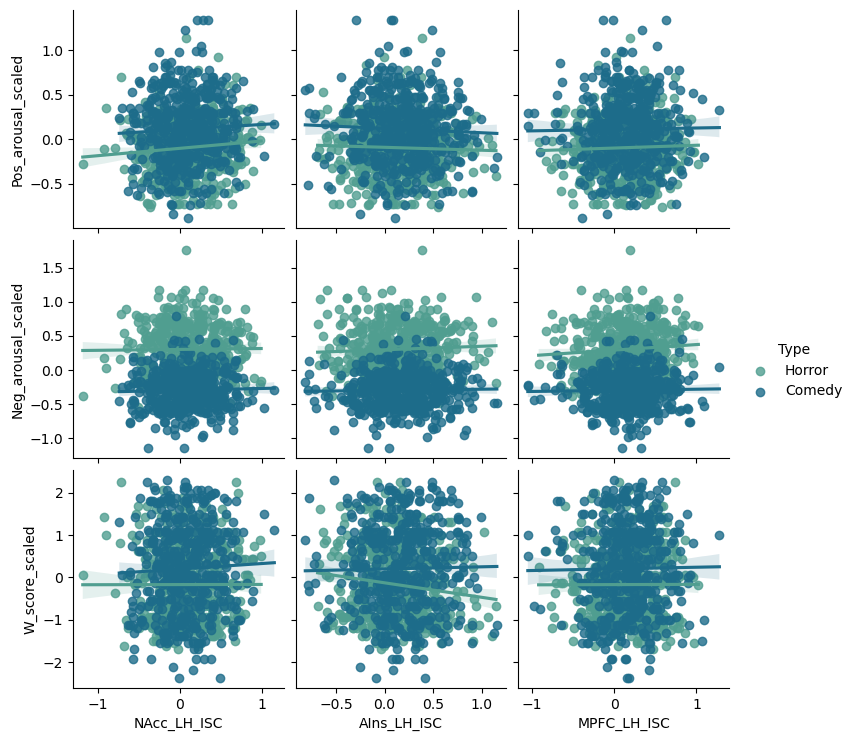

In [24]:
sns.pairplot(
    all_subs_events_df,
    kind="reg",
    x_vars=["NAcc_LH_ISC", "AIns_LH_ISC", "MPFC_LH_ISC",],
    y_vars=["Pos_arousal_scaled", "Neg_arousal_scaled", "W_score_scaled"], 
    hue="Type",
    palette="crest")

In [25]:
"""
# Loop through each trailer.
    for id_trailer in current_sub_trailer_keys: 

        # Create empty array to store the timecourses for the current trailer.
        # Accross all participants except the current participant. 
        current_trailer_timecourses_bNAcc = np.zeros((len(participant_list_filtered2), 15))
        current_trailer_timecourses_bAIns = np.zeros((len(participant_list_filtered2), 15))
        current_trailer_timecourses_bMPFC = np.zeros((len(participant_list_filtered2), 15))

        # Loop through each participant except the current participant.
        for id_sub2 in range(len(participant_list_filtered2)):

            current_sub2 = participant_list_filtered2[id_sub2]

            print(current_sub2)
            # Store the timecourse for the current participant.
            current_trailer_timecourses_bNAcc[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][id_trailer]["Bilateral_NAcc"]
            current_trailer_timecourses_bAIns[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][id_trailer]["Bilateral_AIns"]
            current_trailer_timecourses_bMPFC[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][id_trailer]["Bilateral_MPFC"]

        # Calculate the mean timecourse for the group without the current participant.
        mean_timecourse_bNAcc = np.mean(current_trailer_timecourses_bNAcc, axis=0)
        mean_timecourse_bAIns = np.mean(current_trailer_timecourses_bAIns, axis=0)
        mean_timecourse_bMPFC = np.mean(current_trailer_timecourses_bMPFC, axis=0)

        # Calculate the ISC for the current trailer for the current participant.
        # Store correlation value regardless of significance.
        # Note, there is a bit of an improvement when using the last 10 TRs, compared to the whole time course.
        current_sub_timecourses[id_trailer] = {"Bilateral_NAcc": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][id_trailer]["Bilateral_NAcc"], mean_timecourse_bNAcc)[0]),
                                               "Bilateral_AIns": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][id_trailer]["Bilateral_AIns"], mean_timecourse_bAIns)[0]),
                                               "Bilateral_MPFC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][id_trailer]["Bilateral_MPFC"], mean_timecourse_bMPFC)[0])}
                                              
"""

'\n# Loop through each trailer.\n    for id_trailer in current_sub_trailer_keys: \n\n        # Create empty array to store the timecourses for the current trailer.\n        # Accross all participants except the current participant. \n        current_trailer_timecourses_bNAcc = np.zeros((len(participant_list_filtered2), 15))\n        current_trailer_timecourses_bAIns = np.zeros((len(participant_list_filtered2), 15))\n        current_trailer_timecourses_bMPFC = np.zeros((len(participant_list_filtered2), 15))\n\n        # Loop through each participant except the current participant.\n        for id_sub2 in range(len(participant_list_filtered2)):\n\n            current_sub2 = participant_list_filtered2[id_sub2]\n\n            print(current_sub2)\n            # Store the timecourse for the current participant.\n            current_trailer_timecourses_bNAcc[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][id_trailer]["Bilateral_NAcc"]\n            current_trailer_timecourses_bAIns[id_